In [1]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_functions import *
import matplotlib.pyplot as plt
from biotuner.biotuner2d import*
from biotuner.biotuner_object import *
import mne
from scipy import signal
import warnings
import neurokit2 as nk
import pandas as pd
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

pygame 2.0.2 (SDL 2.0.16, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Convergent validity of harmonicity metrics

First we will load EEG data. 

In [2]:
path = 'C:/Users/Dell/GitHub/biotuner/examples/data_examples/EEG_pareidolia/'
EEG_data = np.load(path+'parei_data_1000ts.npy')
EEG_sf = 1000
EEG_data.shape

(500, 9501)

We will graph a **correlation matrix using all the harmonicity metrics**. We need to specify which *peaks_function* is being used. We will later compare *peaks_function* with each other. First, let's start with *fixed* bands using **5 bands** spanning **1 octave each**. We will use 250 segments of 3 seconds with a precision of 0.5Hz.

[Text(0, 0.5, 'peaks'),
 Text(0, 1.5, 'cons'),
 Text(0, 2.5, 'harmsim'),
 Text(0, 3.5, 'harm_fit'),
 Text(0, 4.5, 'tenney'),
 Text(0, 5.5, 'diss_n_steps'),
 Text(0, 6.5, 'dissonance'),
 Text(0, 7.5, 'matrix_cons'),
 Text(0, 8.5, 'matrix_harm_sim'),
 Text(0, 9.5, 'sum_q_for_all_intervals'),
 Text(0, 10.5, 'sum_distinct_intervals'),
 Text(0, 11.5, 'sum_p_q')]

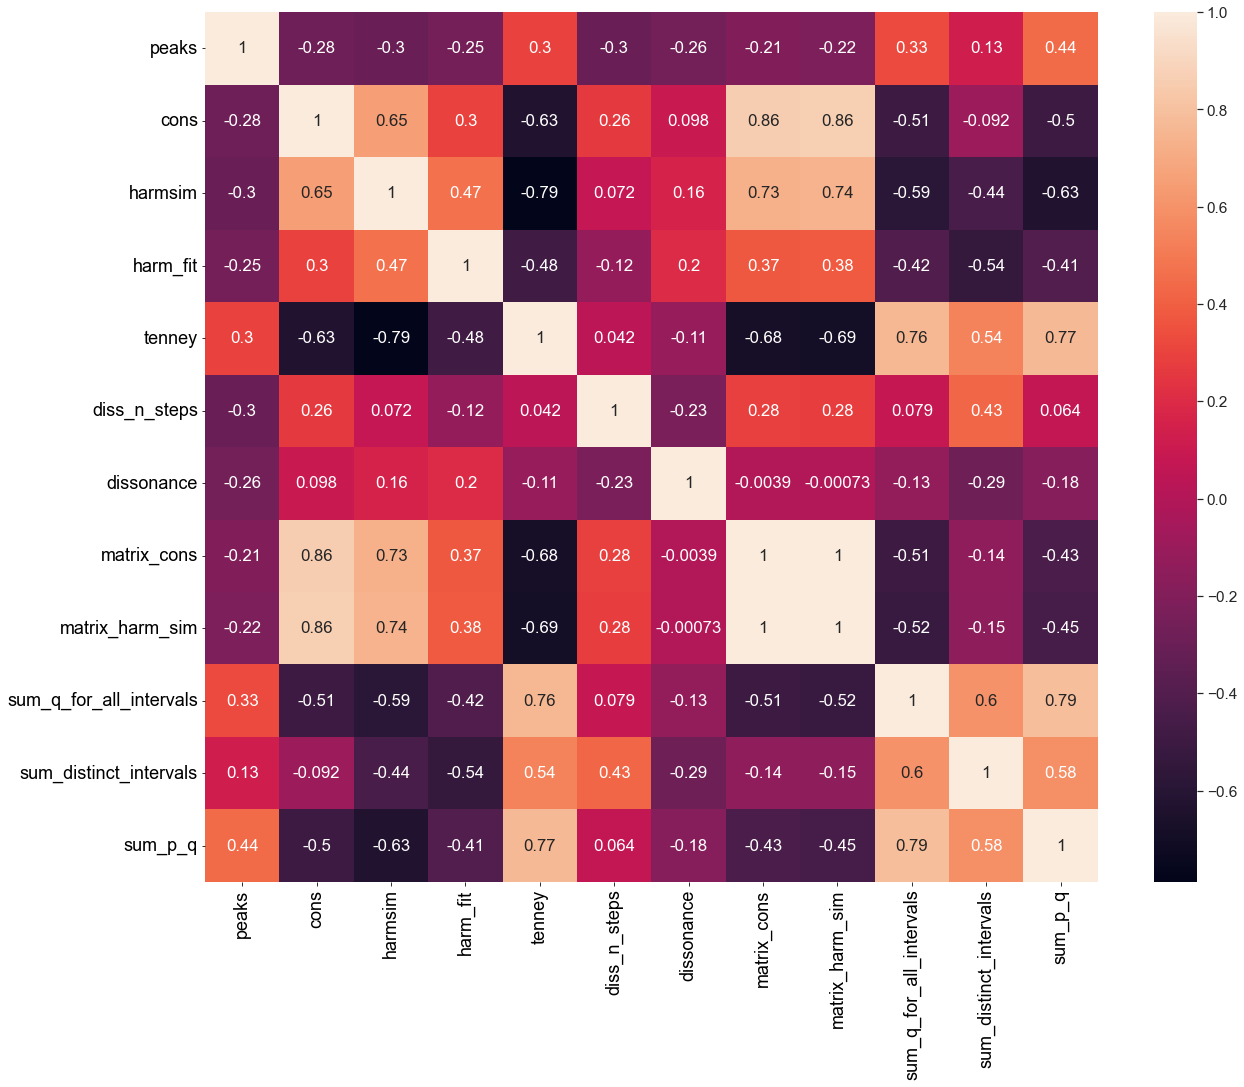

In [16]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
df_metrics = compare_metrics(EEG_data[0:250,2000:5000], 1000, peaks_function='fixed', precision=0.5,
                            min_notes=3, cons_limit=0.1, chords_multiple_metrics=True, add_cons=0.3, add_notes=2, 
                            FREQ_BANDS = FREQ_BANDS)

df_corr = df_metrics.corr()
fig, ax = plt.subplots(figsize=(20,16))
sbn.set(font_scale=1.4)
res = sbn.heatmap(df_corr, annot=True, cmap='rocket')
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)

Let's do the same using Ensemble Empirical Mode Decomposition method (EEMD). 

[Text(0, 0.5, 'peaks'),
 Text(0, 1.5, 'cons'),
 Text(0, 2.5, 'harmsim'),
 Text(0, 3.5, 'tenney'),
 Text(0, 4.5, 'spectro_chords'),
 Text(0, 5.5, 'spectro_chords_cons'),
 Text(0, 6.5, 'spectro_chords_cons+'),
 Text(0, 7.5, 'diss_n_steps'),
 Text(0, 8.5, 'dissonance'),
 Text(0, 9.5, 'matrix_cons'),
 Text(0, 10.5, 'matrix_harm_sim'),
 Text(0, 11.5, 'sum_q_for_all_intervals'),
 Text(0, 12.5, 'sum_distinct_intervals'),
 Text(0, 13.5, 'sum_p_q')]

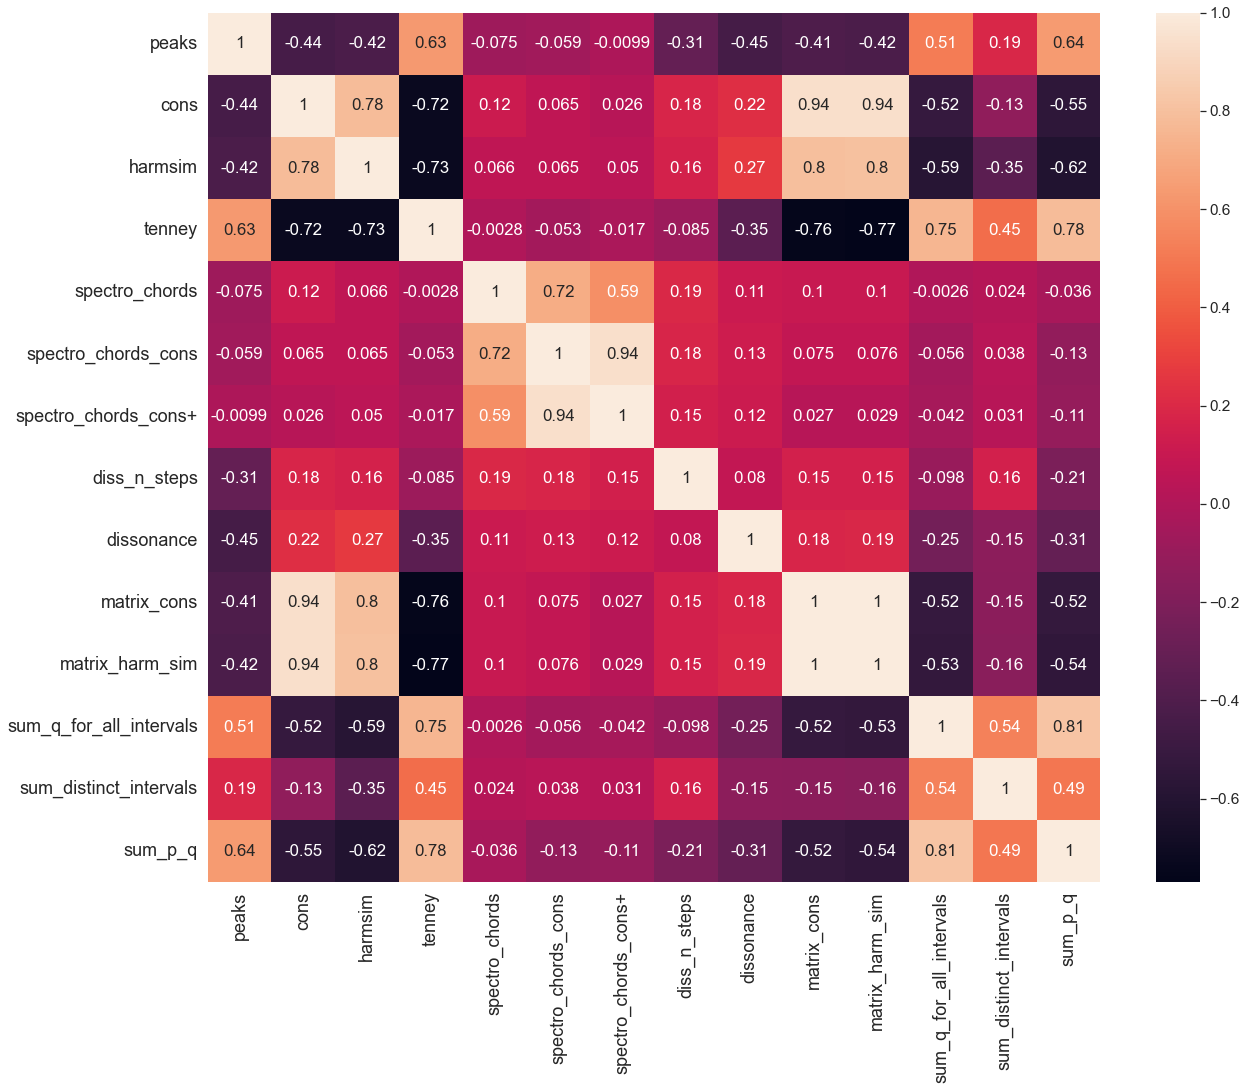

In [4]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
df_metrics = compare_metrics(EEG_data[0:250,2000:5000], 1000, peaks_function='EEMD', precision=0.5,
                            min_notes=3, cons_limit=0.1, chords_metrics=True,
                             chords_multiple_metrics=True, add_cons=0.3, add_notes=2, 
                            FREQ_BANDS = FREQ_BANDS)
df_corr = df_metrics.corr()
fig, ax = plt.subplots(figsize=(20,16))
sbn.set(font_scale=1.4)
res = sbn.heatmap(df_corr, annot=True, cmap='rocket')
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)

Since this method uses dyadic filter bank (octave filter bank) to decompose the signal into Intrinsic Mode Functions, we expect that harmonicity metrics might have slightly higher scores as compared to other methods. To test this, we will **plot the average of all metrics for different peak extraction methods**.

The *compare_corr_metrics_peaks* function takes an array of *trials * time_series* and return two dataframes in the shape *peaks_functions * harmonicity_metrics* of the correlation  with the averaged peaks frequency (*df_peaks_tot*) and their associated p-values (*df_p_EEG*). 

It also returns a list of dataframes (one per peaks function) in the shape *harmonicity metrics * trials*. (*df_metrics_all*)

In [61]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['HH1D_max', 'harmonic_peaks', 'fixed', 'adapt', 'EMD', 'EEMD', 'FOOOF']
df_peaks_EEG, df_p_EEG, df_metrics_EEG = compare_corr_metrics_peaks(EEG_data[0:250, 2000:5000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=3, cons_limit=0.1, chords_metrics=False)

harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF


Then, we will plot the **average of all metrics correlation** to see if it varies **across peak extraction methods**

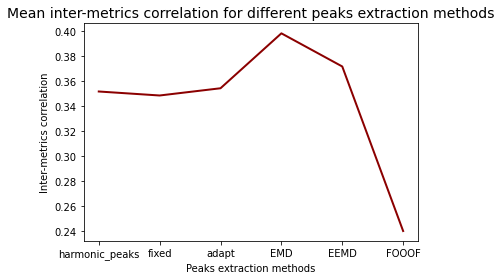

In [86]:
df_metrics_corr_avg = pd.DataFrame()
for method in range(len(df_metrics_all)):
    df_metrics_corr_avg[peaks_functions[method]] = [np.average(abs(df_metrics_all[method].iloc[:, 1:].corr()))]


plt.plot(df_metrics_corr_avg.loc[0], color='darkred', linewidth=2)
plt.title('Mean inter-metrics correlation for different peaks extraction methods', fontsize=14)
plt.xlabel('Peaks extraction methods')
plt.ylabel('Inter-metrics correlation')
plt.show()
#df_metrics_corr_avg

We will do the same but with a peak precision of **0.1Hz** instead of 0.5Hz to see if the results are constant

In [95]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['harmonic_peaks', 'fixed', 'adapt', 'EMD', 'EEMD', 'FOOOF']
df_peaks_EEG2, df_metrics_EEG2 = compare_corr_metrics_peaks(EEG_data[0:250, 4000:9000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.1, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=3, cons_limit=0.1, chords_metrics=False)

harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF


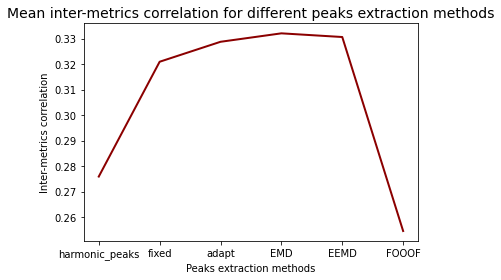

In [96]:
df_metrics_corr_avg = pd.DataFrame()
for method in range(len(df_metrics_EEG2)):
    df_metrics_corr_avg[peaks_functions[method]] = [np.average(abs(df_metrics_EEG2[method].iloc[:, 1:].corr()))]


plt.plot(df_metrics_corr_avg.loc[0], color='darkred', linewidth=2)
plt.title('Mean inter-metrics correlation for different peaks extraction methods', fontsize=14)
plt.xlabel('Peaks extraction methods')
plt.ylabel('Inter-metrics correlation')
plt.show()
#df_metrics_corr_avg

## How do harmonicity metrics are affected by averaged frequency values ?

Since the *Biotuner* computes hamonicity metrics on frequency peaks, we want to observe how these metrics correlate with the averaged frequency of their input. In other words, **are lower frequencies more consonant than higher frequencies ?** 

To answer this question, we will look at how the correlation between mean frequency and harmonicity metrics varies across peak extraction methods.

In [273]:
df_sorted_EEG = df_peaks_EEG.sort_values(by = ['EEMD', 'EMD', 'fixed', 'adapt', 'FOOOF', 'harmonic_peaks'])
df_sorted_EEG = df_sorted_EEG #we remove the correlation of peaks with peaks (always equals 1)

<function matplotlib.pyplot.show(close=None, block=None)>

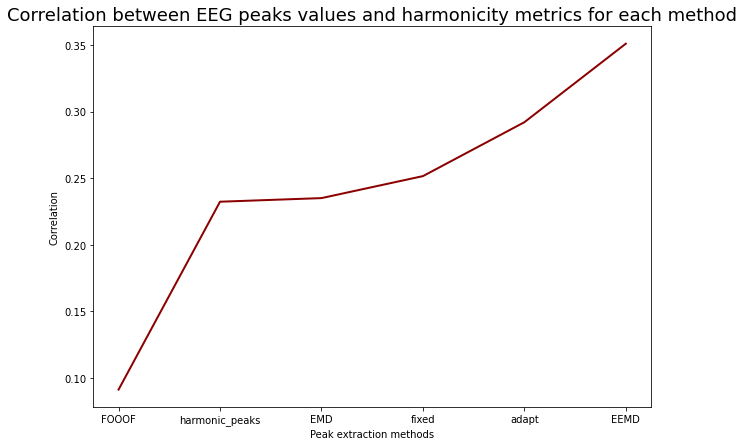

In [89]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG.mean(axis=0).sort_values(), color = 'darkred', linewidth=2)
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics for each method', fontsize=18)
plt.xlabel('Peak extraction methods')
plt.ylabel('Correlation')
plt.show

Here we explore how harmonicity metrics correlate with frequency peaks in average of all peak extraction methods

<function matplotlib.pyplot.show(close=None, block=None)>

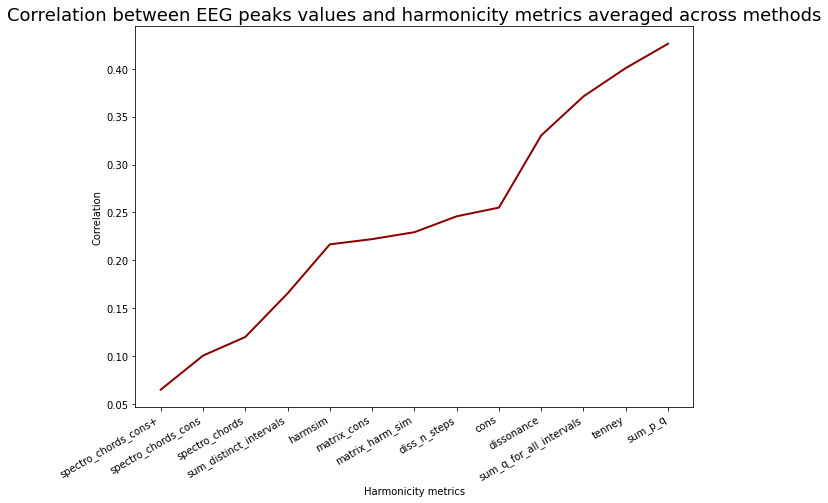

In [90]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG.mean(axis=1).sort_values(), color = 'darkred', linewidth=2)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics averaged across methods', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

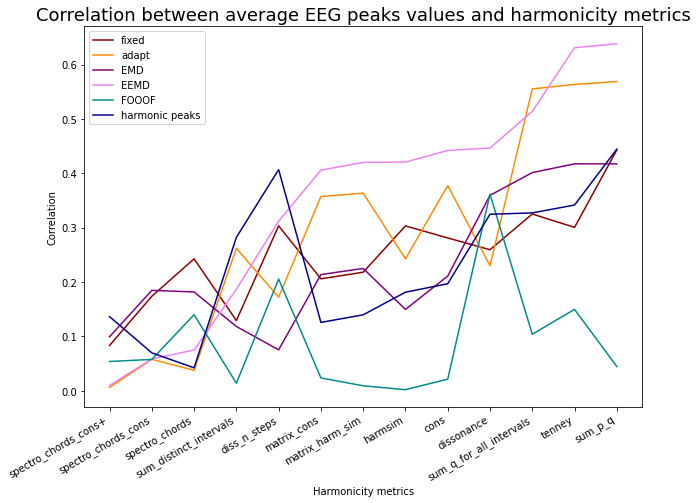

In [93]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG['fixed'], color='darkred', label="fixed")
plt.plot(df_sorted_EEG['adapt'], color='darkorange', label="adapt")
plt.plot(df_sorted_EEG['EMD'], color='purple', label="EMD")
plt.plot(df_sorted_EEG['EEMD'], color='violet', label="EEMD")
plt.plot(df_sorted_EEG['FOOOF'], color='darkcyan', label="FOOOF")
plt.plot(df_sorted_EEG['harmonic_peaks'], color='darkblue', label="harmonic peaks")
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between average EEG peaks values and harmonicity metrics', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.show

### We will do the same analyses with peaks precision at 0.1Hz

In [97]:
df_sorted_EEG2 = df_peaks_EEG2.sort_values(by = ['EEMD', 'EMD', 'fixed', 'adapt', 'FOOOF', 'harmonic_peaks'])
df_sorted_EEG2 = df_sorted_EEG2.iloc[:-1] #we remove the correlation of peaks with peaks (always equals 1)

harmonic_peaks     fixed     adapt       EMD  \
spectro_chords_cons            0.281161  0.193293  0.002376  0.077057   
spectro_chords_cons+           0.052800  0.059765  0.099957  0.118170   
sum_distinct_intervals         0.033458  0.096621  0.139295  0.126917   
spectro_chords                 0.328876  0.203265  0.013070  0.021922   
diss_n_steps                   0.217241  0.319033  0.092513  0.136091   
matrix_cons                    0.083710  0.097361  0.196131  0.228430   
harmsim                        0.037962  0.000147  0.186842  0.203409   
cons                           0.027475  0.066709  0.309177  0.281221   
matrix_harm_sim                0.068448  0.107797  0.229488  0.243612   
dissonance                     0.523427  0.333035  0.571889  0.379238   
tenney                         0.336392  0.041733  0.463407  0.432930   
sum_q_for_all_intervals        0.048480  0.170992  0.435472  0.419603   
sum_p_q                        0.024652  0.276294  0.516670  0.393263   

                             EEMD     FOOOF  
spectro_chords_cons      0.030449  0.252348  
spectro_chords_cons+     0.045577  0.192623  
sum_distinct_intervals   0.060859  0.515667  
spectro_chords           0.068899  0.326392  
diss_n_steps             0.180111  0.195716  
matrix_cons              0.190118  0.037248  
harmsim                  0.193363  0.037097  
cons                     0.196541  0.064264  
matrix_harm_sim          0.197023  0.051979  
dissonance               0.358474  0.033127  
tenney                   0.365539  0.001507  
sum_q_for_all_intervals  0.397922  0.199739  
sum_p_q                  0.417104  0.113815

<function matplotlib.pyplot.show(close=None, block=None)>

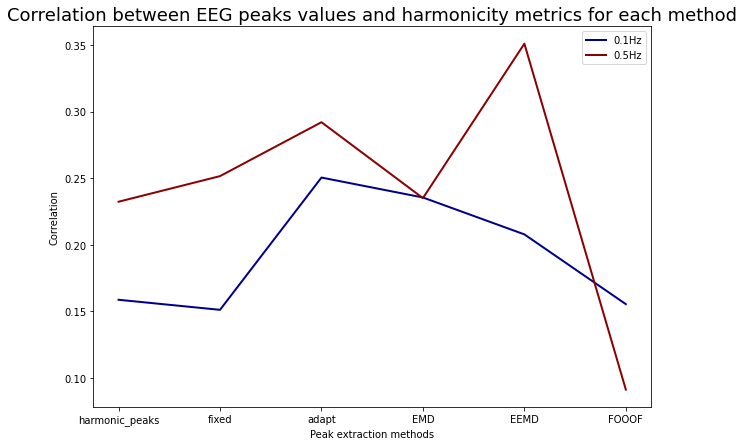

In [123]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG2.mean(axis=0), color = 'darkblue', linewidth=2, label='0.1Hz')
plt.plot(df_sorted_EEG.mean(axis=0), color = 'darkred', linewidth=2, label='0.5Hz')
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics for each method', fontsize=18)
plt.legend()
plt.xlabel('Peak extraction methods')
plt.ylabel('Correlation')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

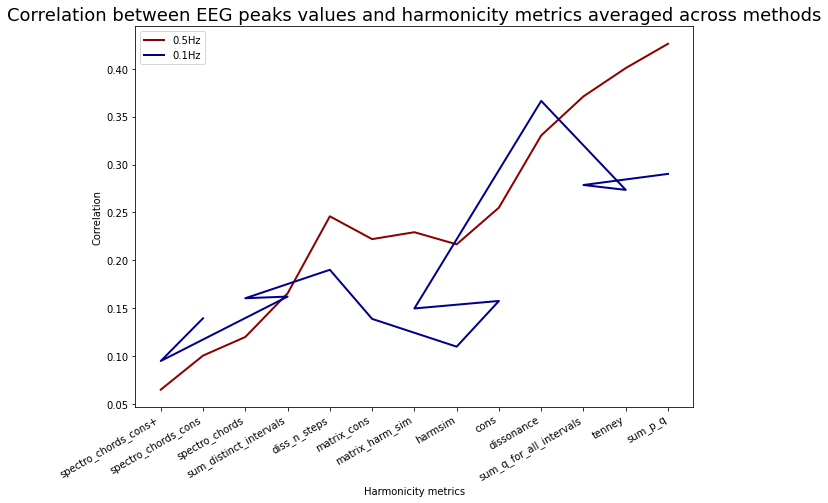

In [124]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG.mean(axis=1), color = 'darkred', linewidth=2, label='0.5Hz')
plt.scatter(df_sorted_EEG2.mean(axis=1), color = 'darkblue', linewidth=2, label='0.1Hz')

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics averaged across methods', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

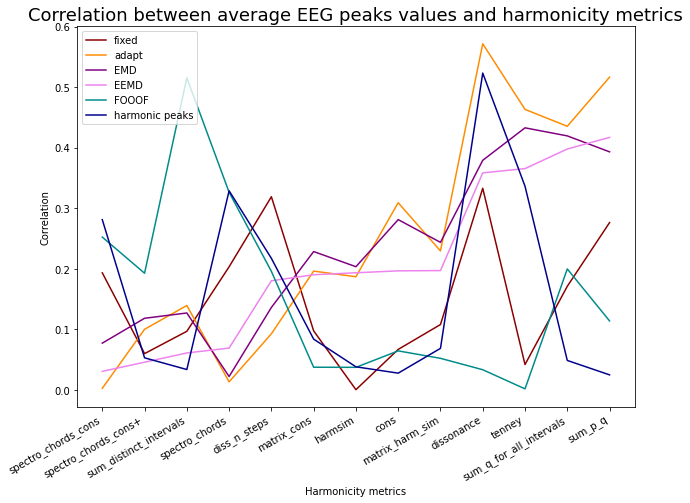

In [100]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG2['fixed'], color='darkred', label="fixed")
plt.plot(df_sorted_EEG2['adapt'], color='darkorange', label="adapt")
plt.plot(df_sorted_EGG2['EMD'], color='purple', label="EMD")
plt.plot(df_sorted_EEG2['EEMD'], color='violet', label="EEMD")
plt.plot(df_sorted_EEG2['FOOOF'], color='darkcyan', label="FOOOF")
plt.plot(df_sorted_EEG2['harmonic_peaks'], color='darkblue', label="harmonic peaks")
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between average EEG peaks values and harmonicity metrics', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.show

## Which harmonicity metrics best distinguish between EEG and ECG ?

To answer this questions, we will compute the metrics for *n* trials for both EEG and ECG signals, using all the peaks extraction methods. 

To read a harmonicity metrics dataframe, use: 

*df_metrics = pd.read_csv(fname+'.csv', index_col='method')*

To read the *peaks_corr* and *peaks_p* dataframes, use:

*df_peaks_corr = pd.read_csv(fname+'peaks_corr.csv', index_col='index')*

In [90]:
#ECG
path = 'data_examples/ECG/'
data = mne.io.read_raw_edf(path + '/r01.edf', preload = True)
ECG_data = data.load_data()
ECG_data = ECG_data.get_data()
ECG_sf = 1000
ECG_data = slice_data(ECG_data[0:4], ECG_sf, window=5)
ECG_data.shape
EEG_data, ECG_data = equate_dimensions(EEG_data, ECG_data)


Extracting EDF parameters from C:\Users\Dell\GitHub\biotuner\examples\data_examples\ECG\r01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...


In [91]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions = ['fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'FOOOF', 'FOOOF_EEMD', 'HH1D_max', 'EMD', 'EEMD']
peaks_corr_ECG, peaks_p_ECG, ECG_metrics = compare_corr_metrics_peaks(ECG_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          chords_metrics=False, save=True, fname='ECG_metrics_0.5Hz')

peaks_corr_EEG, peaks_p_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          chords_metrics=False, save=True, fname='EEG_metrics_0.5Hz')


fixed
adapt
cepstrum
harmonic_peaks
FOOOF
FOOOF_EEMD
HH1D_max
EMD
EEMD
fixed
adapt
cepstrum
harmonic_peaks
FOOOF
FOOOF_EEMD
HH1D_max
EMD
EEMD


We will look at how the correlation between peak frequencies and harmonicity metrics differs between ECG and EEG.

We can see that values are comparable.

<function matplotlib.pyplot.show(close=None, block=None)>

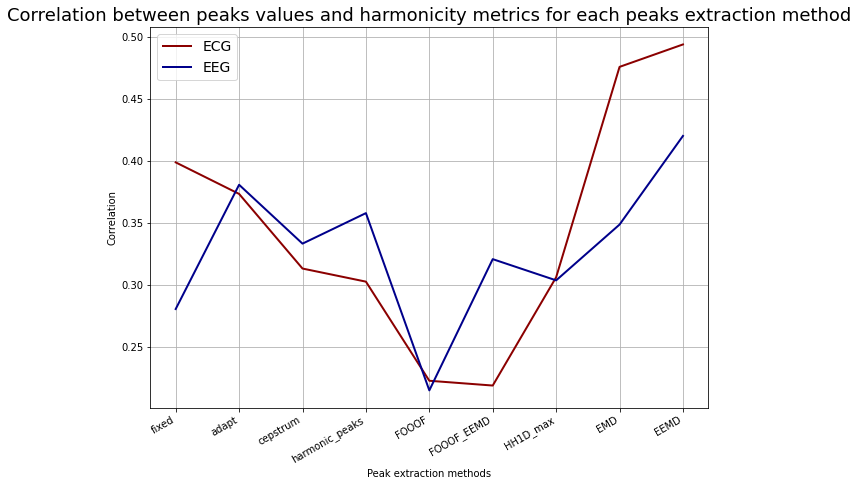

In [193]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(peaks_corr_ECG.mean(axis=0), color = 'darkred', linewidth=2, label="ECG")
plt.plot(peaks_corr_EEG.mean(axis=0), color = 'darkblue', linewidth=2, label='EEG')
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between peaks values and harmonicity metrics for each peaks extraction method', fontsize=18)
plt.xlabel('Peak extraction methods')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.legend(fontsize=14)
plt.grid()
plt.ylabel('Correlation')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

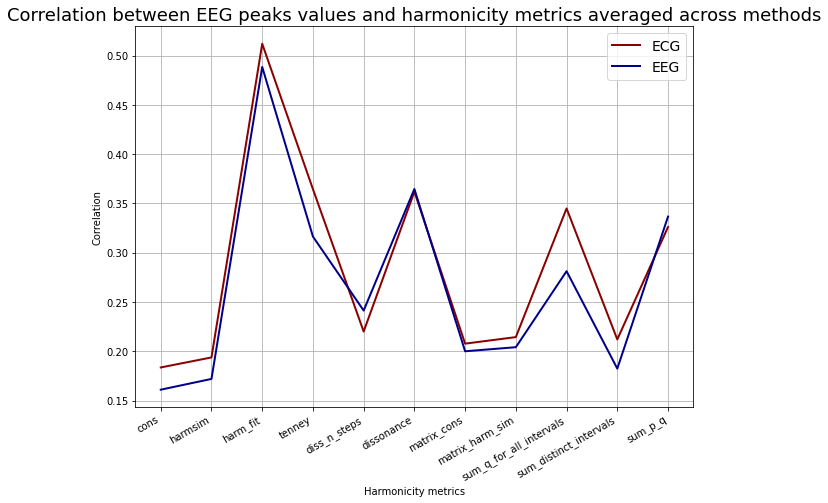

In [191]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(peaks_corr_ECG.mean(axis=1)[1:], color = 'darkred', linewidth=2, label='ECG')
plt.plot(peaks_corr_EEG.mean(axis=1)[1:], color = 'darkblue', linewidth=2, label='EEG')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics averaged across methods', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.grid()
plt.legend(fontsize=14)
plt.show

### We will evaluate with Analyses of Covariance (ANCOVA) which harmonicity metrics and peaks extraction functions best distinguish between ECG and EEG signals.

On the following graphs, the line corresponds to p values of the ANCOVA **comparing the two distributions for each harmonicity metric, while controlling for peaks frequencies**. The dots correspond to the *p value* of the correlation between each metric and the peak frequencies. The triangles appear only for metrics that are significant and their color indicate which data type (e.g. EEG or ECG) has higher mean value for the corresponding metric.

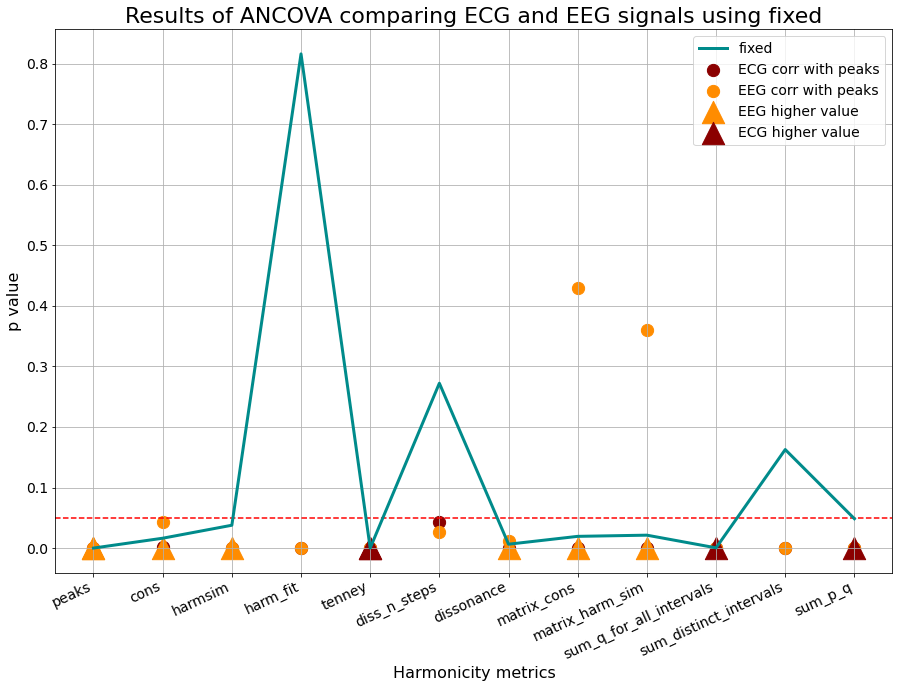

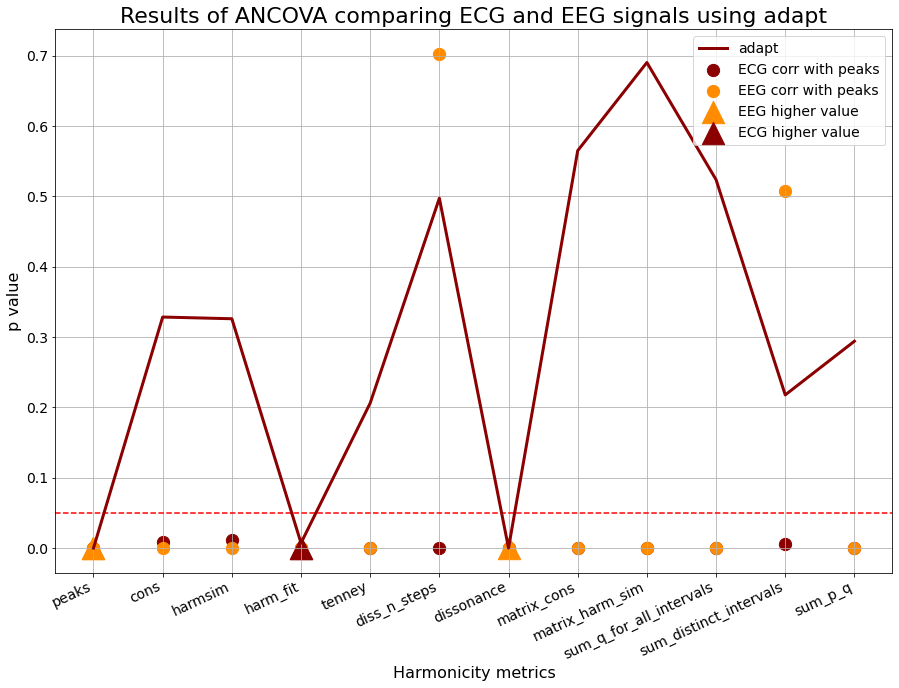

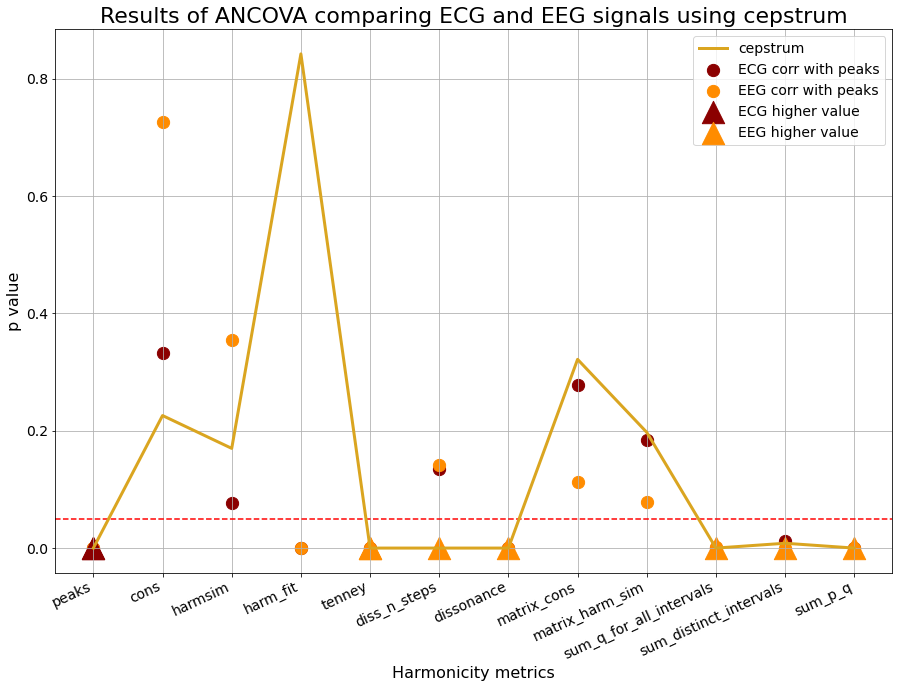

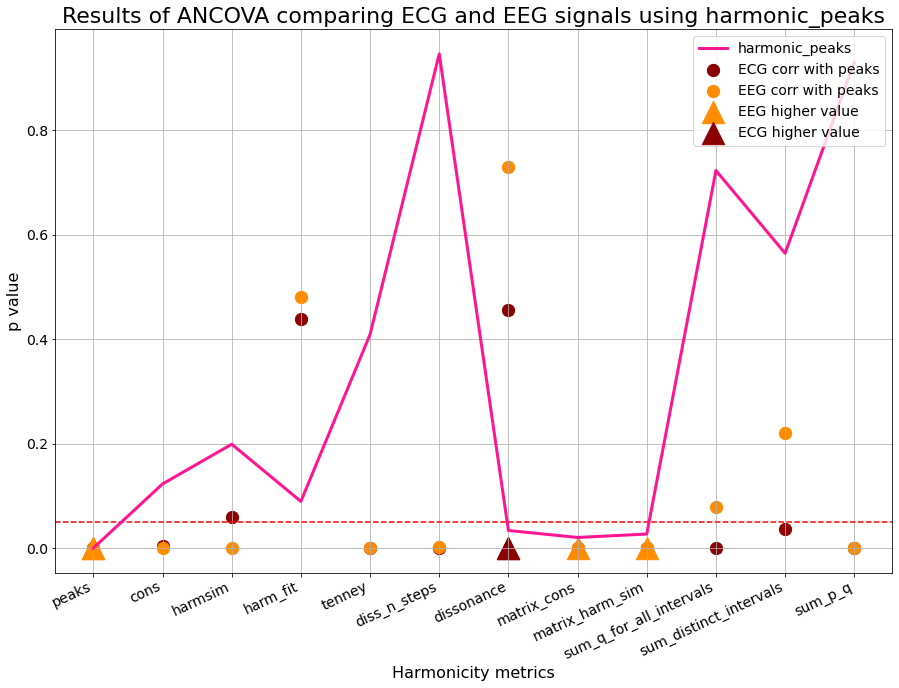

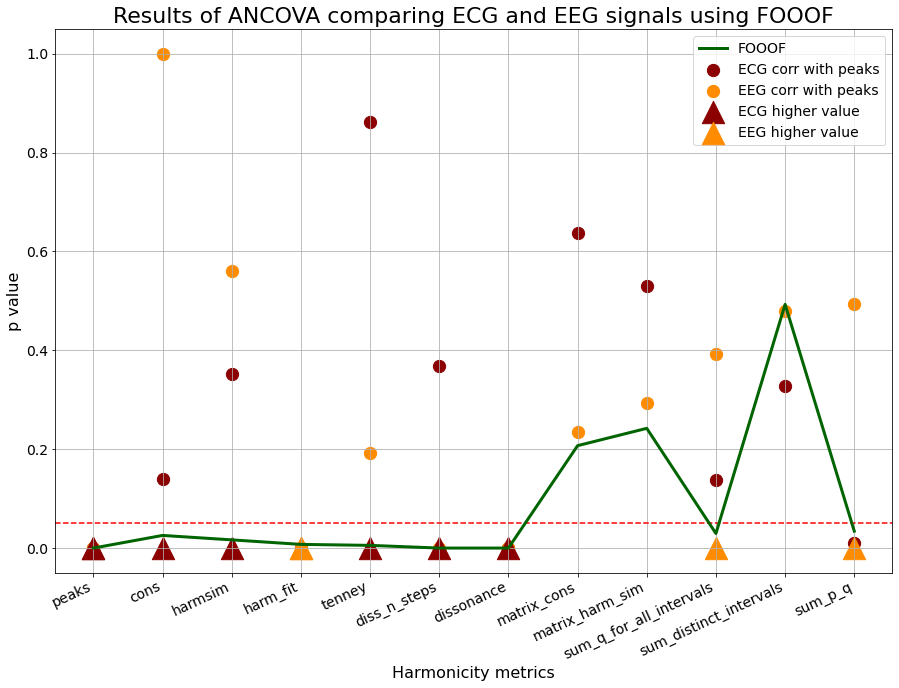

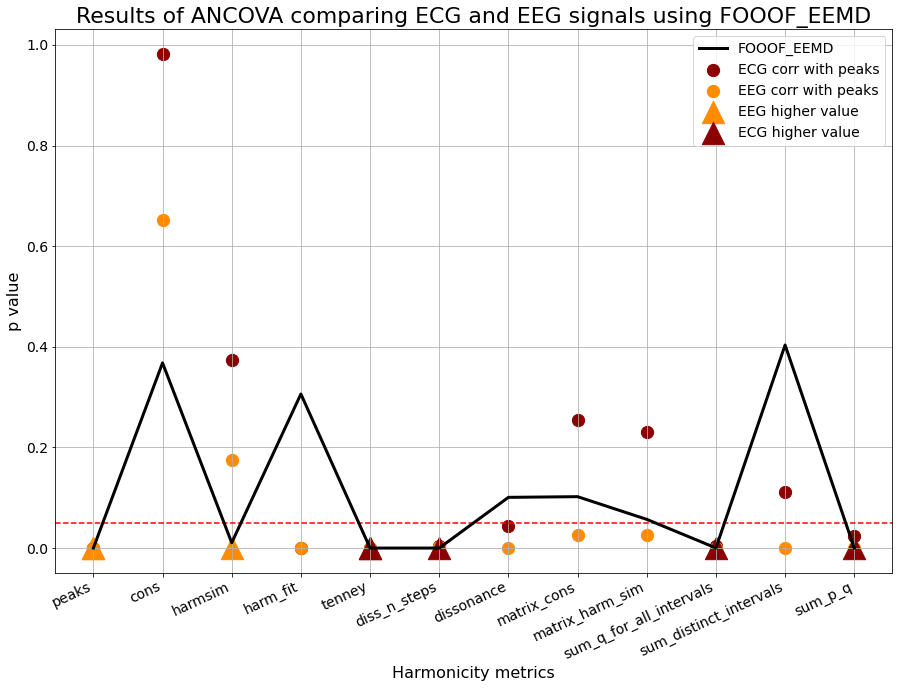

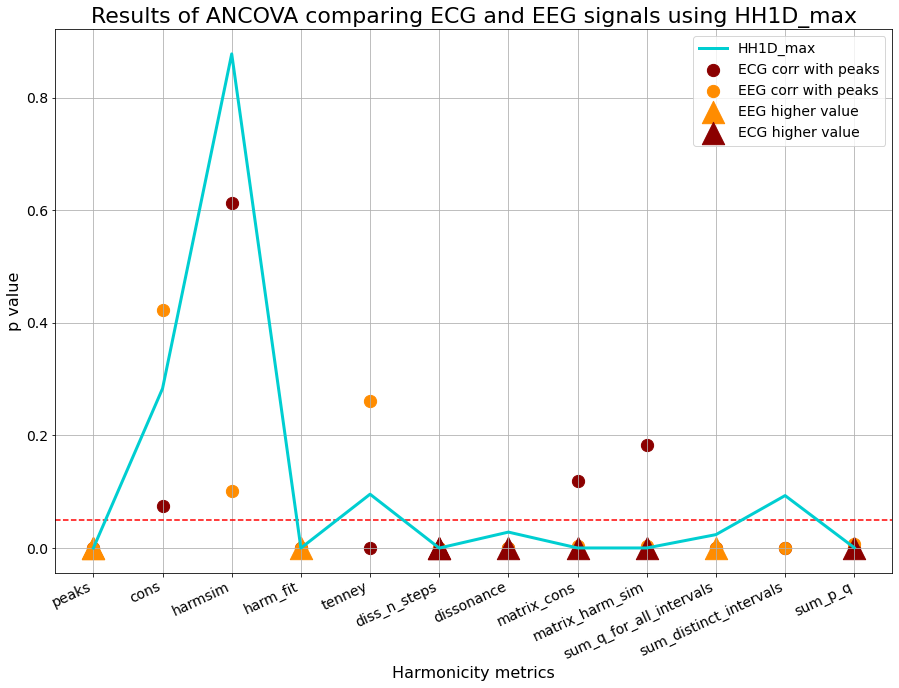

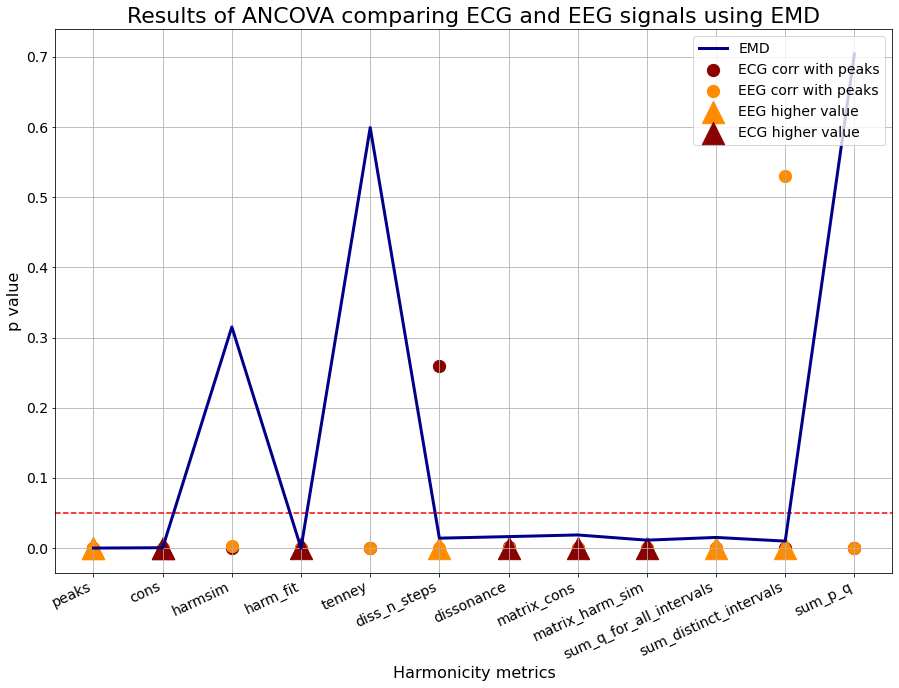

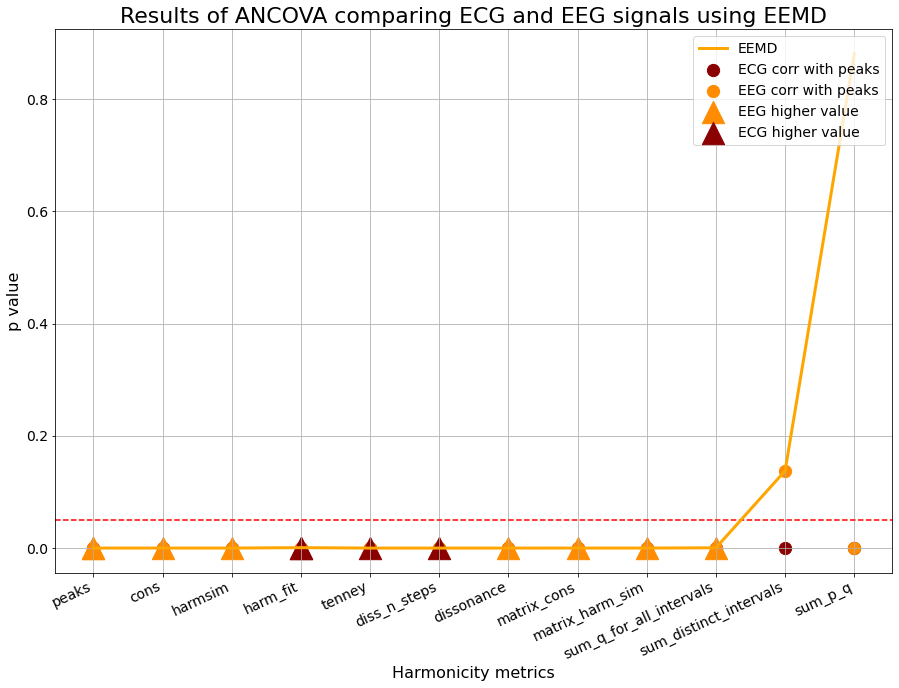

In [110]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all, tvals, avg_all = ttest_all_metrics_all_functions(ECG_metrics, EEG_metrics, peaks_functions, data_types=['ECG', 'EEG'])
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise', 'darkblue', 'orange']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all, function, labels = ['ECG', 'EEG'], 
                           peaks_corr1=peaks_p_ECG, peaks_corr2=peaks_p_EEG, color=color, save=True, avg_all=avg_all)

      Source            SS   DF          F         p-unc       np2
0  data_type    512.074687    1  19.405687  1.306740e-05  0.039171
1      peaks   1618.384903    1  61.330645  3.164863e-14  0.114139
2   Residual  12560.624642  476        NaN           NaN       NaN


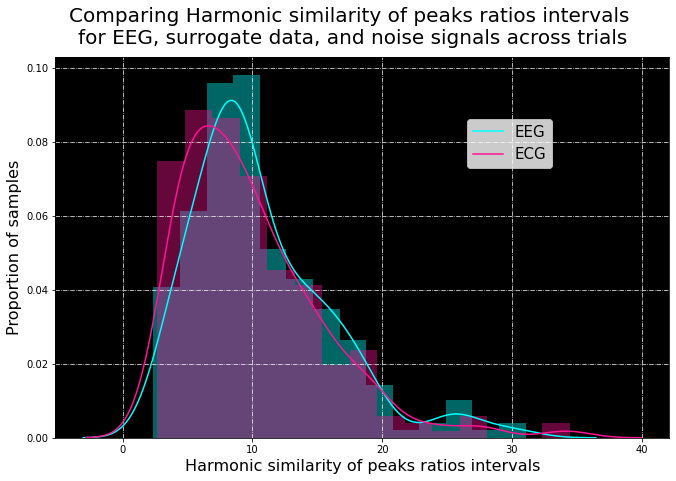

In [183]:
method ='EEMD'
metric='matrix_harm_sim'
data_types=['EEG', 'ECG']
print(ancova_biotuner2d(EEG_metrics, ECG_metrics, method, metric, data_types, plot=False))

test_graph = [EEG_metrics.loc[method][metric], ECG_metrics.loc[method][metric]]
graph_dist(test_graph, metric = metric, ref = test_graph[0], dimensions = [0], labs = ['EEG', 'ECG'], 
           savefolder = '\\', subject = '0', tag = '0', adapt = 'False', 
           peaks_function = method, colors = None, display = True, save = False, title=None)

## Which harmonicity metrics best distinguish between EEG and pink noise ?

In [3]:
path = 'C:/Users/Dell/GitHub/biotuner/examples/data_examples/EEG_pareidolia/'
EEG_data = np.load(path+'parei_data_1000ts.npy')
EEG_sf = 1000
EEG_data.shape

(500, 9501)

In [15]:
pink_data = surrogate_signal_matrices(EEG_data[0:240, 2000:7000], surr_type = 'pink', low_cut = 0.5, high_cut = 150, sf = 1000)

In [7]:
EEG_metrics = pd.read_csv('EEG_metrics_0.5Hz.csv', index_col='index')
peaks_p_eeg = pd.read_csv('EEG_metrics_0.5Hzpeaks_p.csv', index_col='index')
pink_metrics = pd.read_csv('pink_metrics_0.5Hz.csv', index_col='index')
peaks_p_pink = pd.read_csv('pink_metrics_0.5Hzpeaks_p.csv', index_col='index')

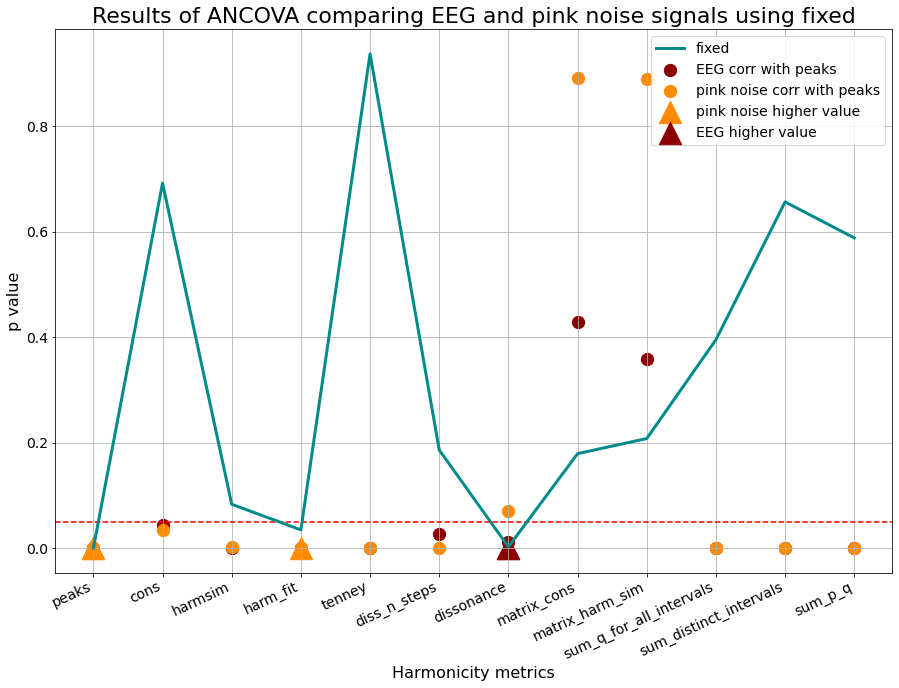

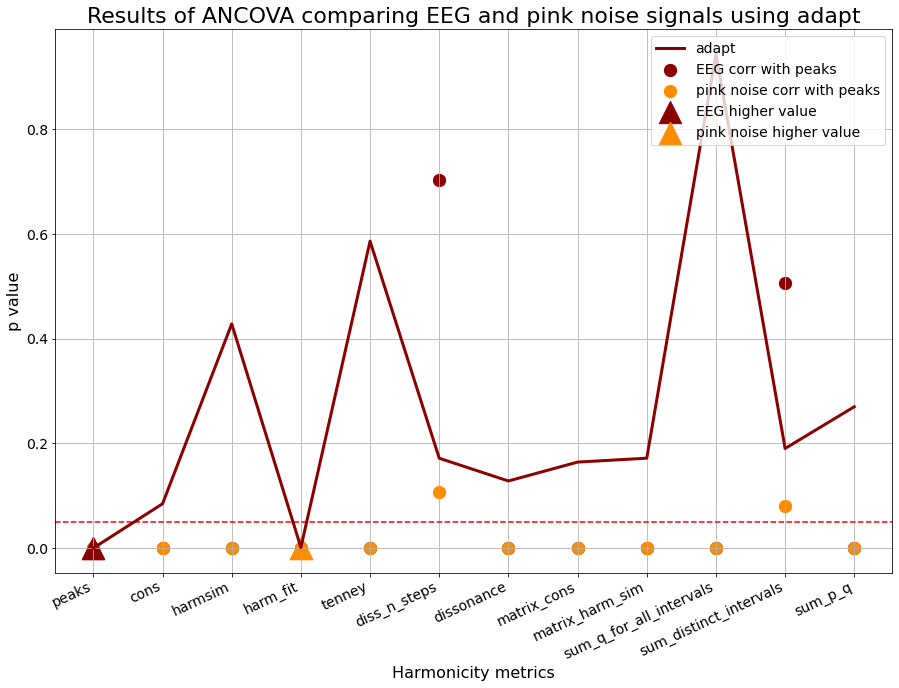

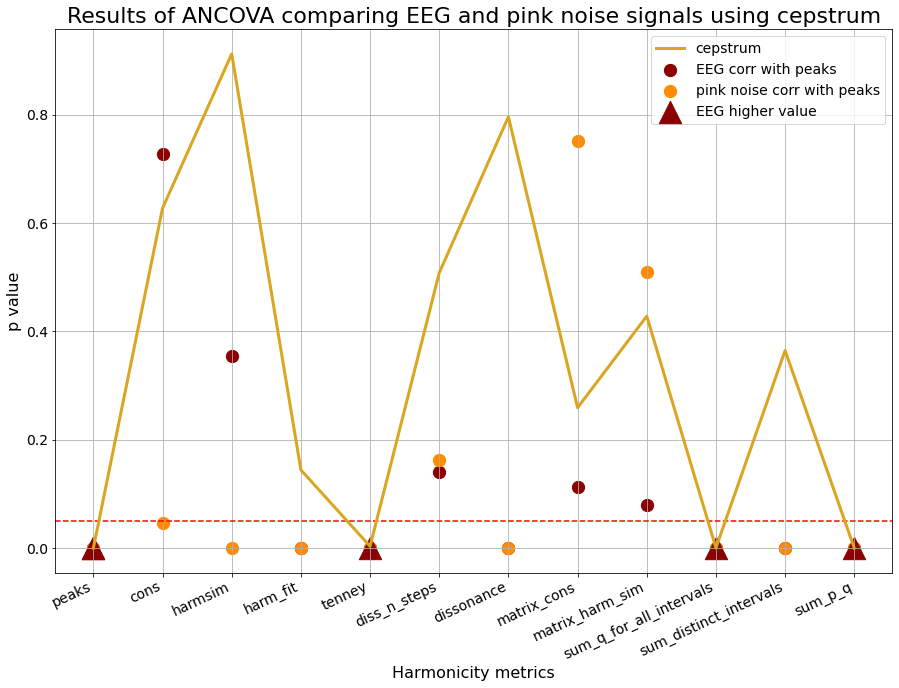

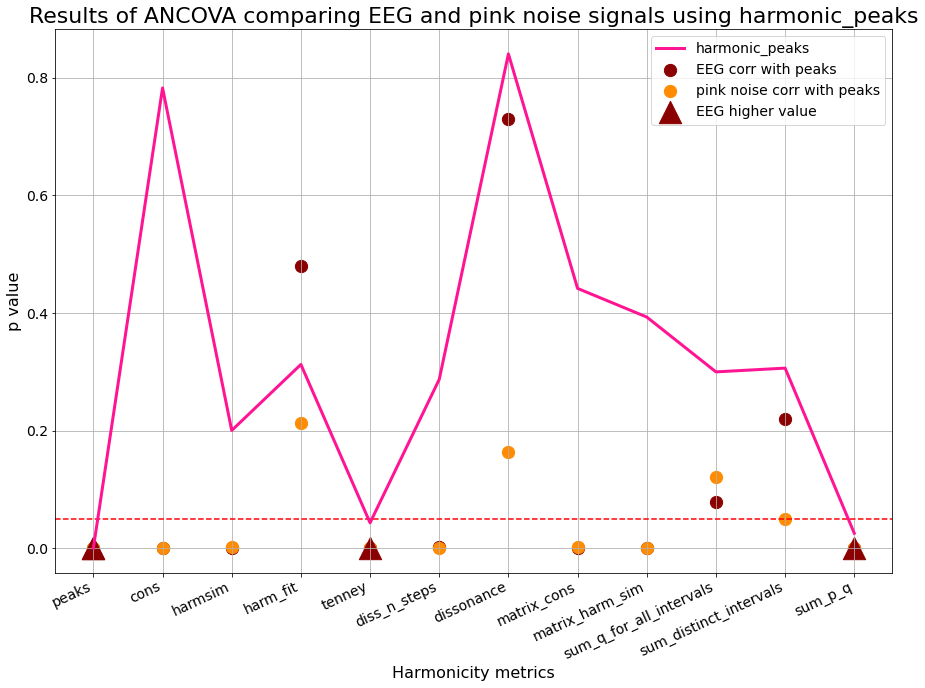

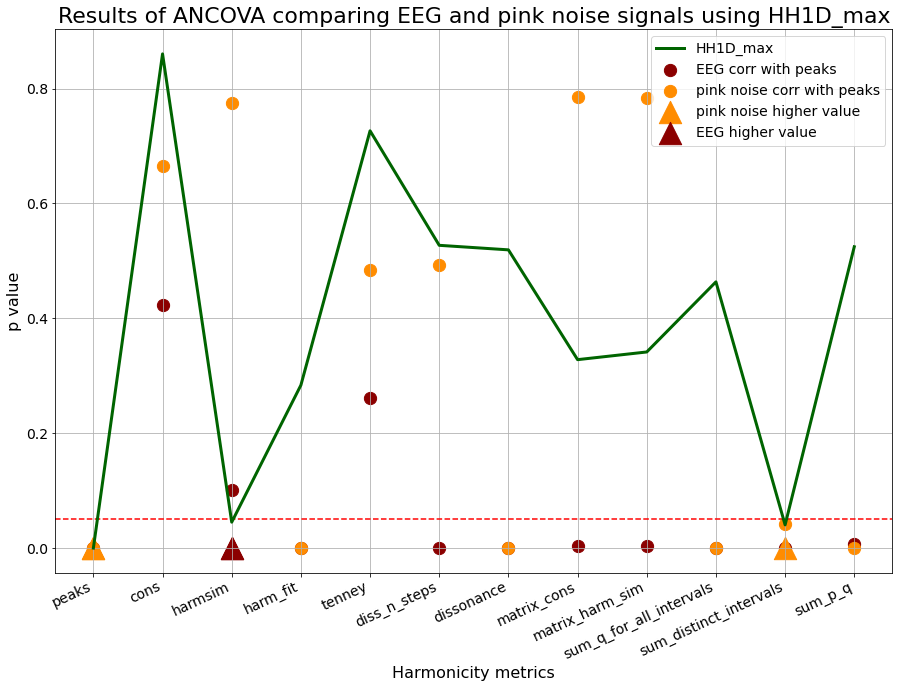

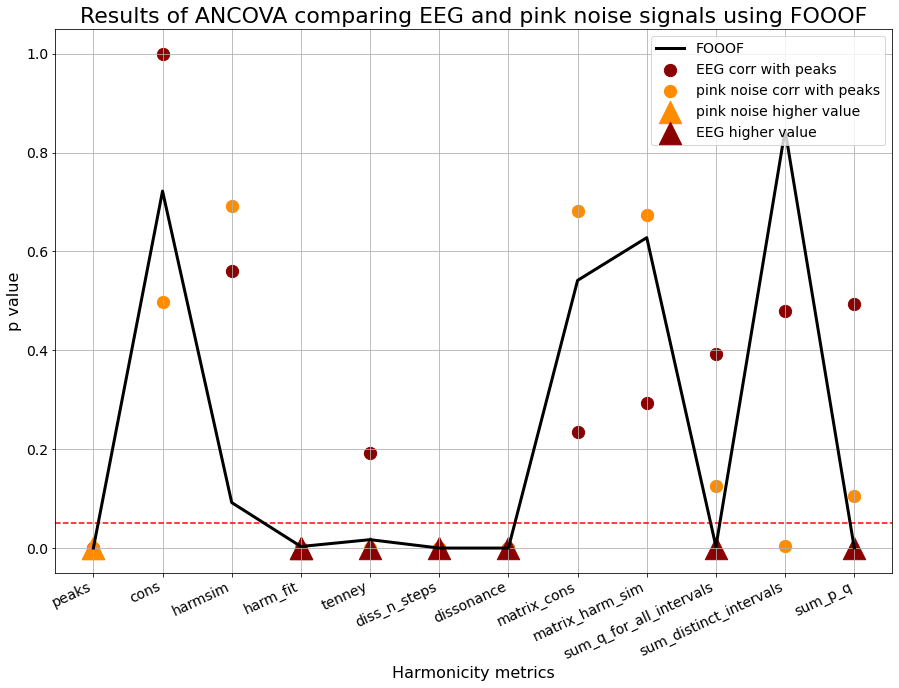

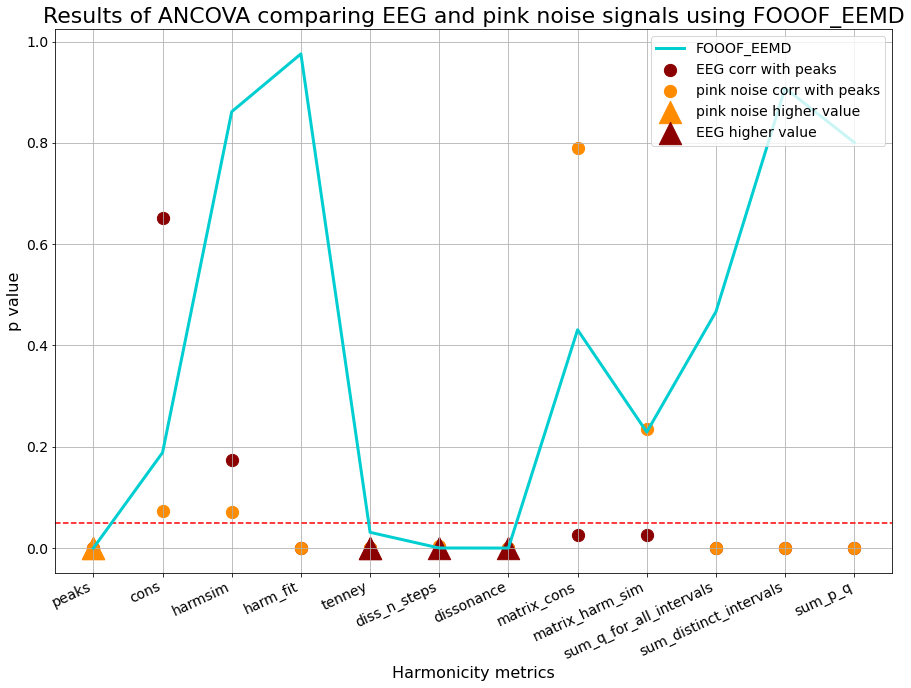

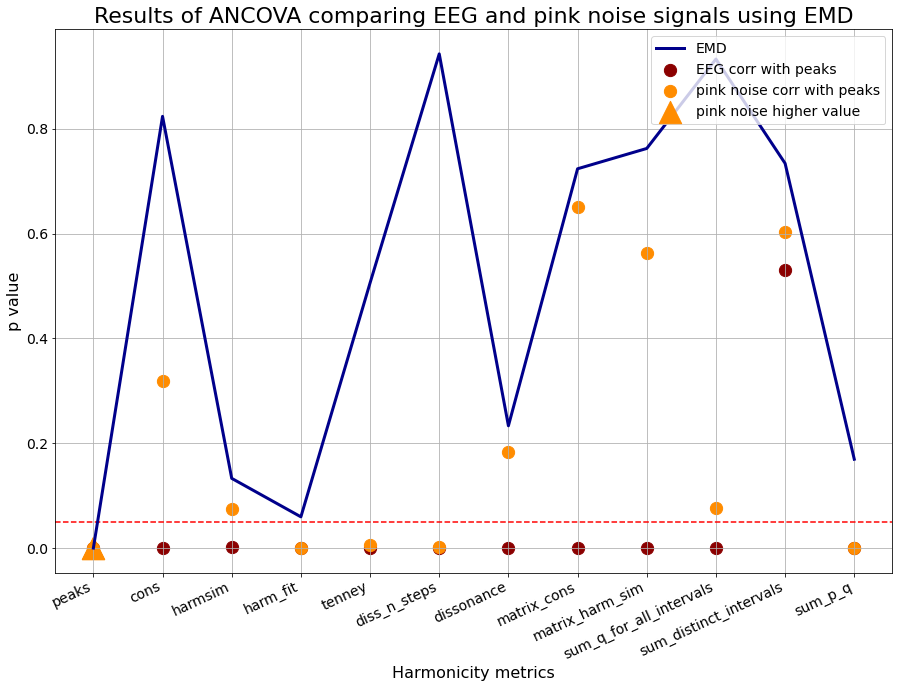

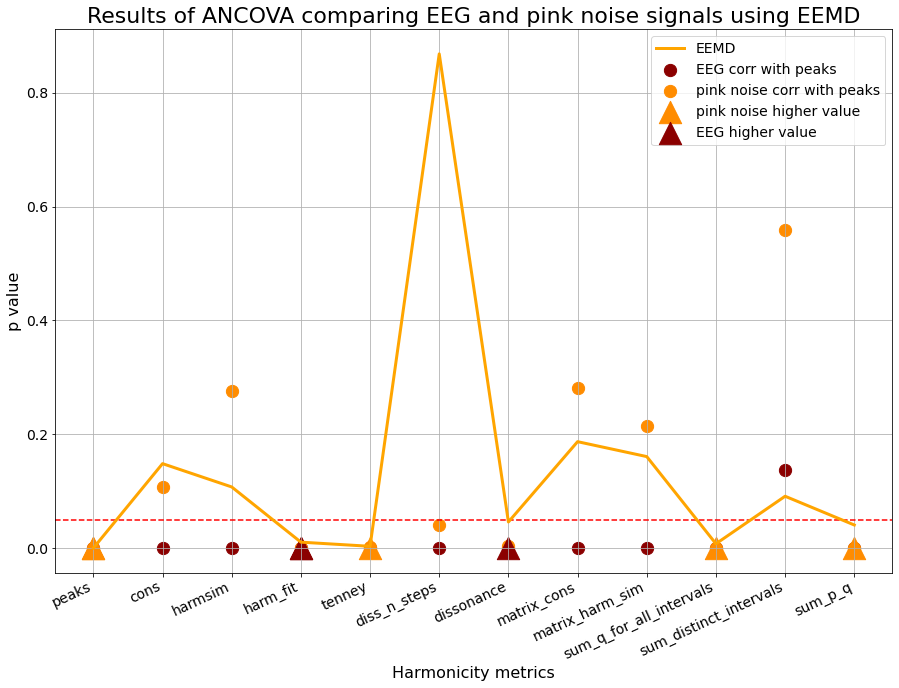

In [29]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all, tvals, avg_all = ttest_all_metrics_all_functions(EEG_metrics, pink_metrics, 
                                                            peaks_functions, data_types=['EEG', 'pink'])
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise', 'darkblue', 'orange']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all, function, labels = ['EEG', 'pink noise'], 
                           peaks_corr1=peaks_p_eeg, peaks_corr2=peaks_p_pink, color=color, save=True, avg_all=avg_all)

      Source           SS   DF           F         p-unc       np2
0  data_type    29.610553    1    6.618196  1.039555e-02  0.013685
1      peaks   507.840155    1  113.506353  6.403207e-24  0.192219
2   Residual  2134.151512  477         NaN           NaN       NaN


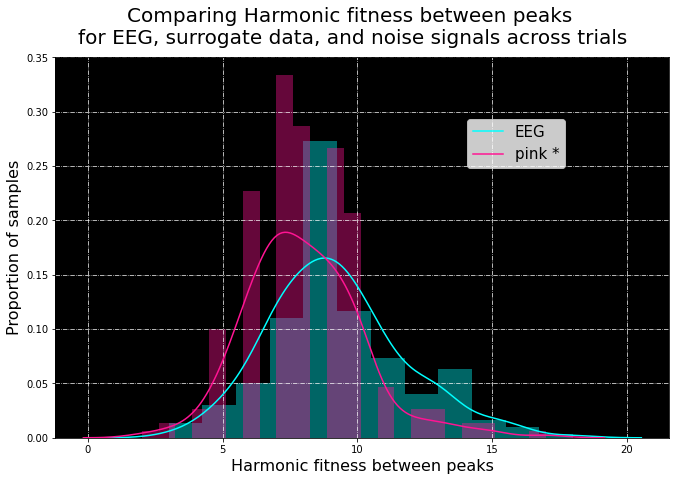

In [9]:
method ='EEMD'
metric='harm_fit'
data_types=['EEG', 'pink']
print(ancova_biotuner2d(EEG_metrics, pink_metrics, method, metric, data_types, plot=False))

test_graph = [EEG_metrics.loc[method][metric], pink_metrics.loc[method][metric]]
graph_dist(test_graph, metric = metric, ref = test_graph[0], dimensions = [0], labs = ['EEG', 'pink'], 
           savefolder = '\\', subject = '0', tag = '0', adapt = 'False', 
           peaks_function = method, colors = None, display = True, save = False, title=None)

In [10]:
pink_metrics = pd.read_csv('pink_metrics_0.1Hz.csv', index_col='index')
EEG_metrics =  pd.read_csv('EEG_metrics_0.1Hz.csv', index_col='index')
peaks_p_eeg =  pd.read_csv('EEG_metrics_0.1Hzpeaks_p.csv', index_col='index')
peaks_p_pink =  pd.read_csv('pink_metrics_0.1Hzpeaks_p.csv', index_col='index')

In [ ]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions = ['fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'FOOOF', 'FOOOF_EEMD', 'HH1D_max', 'EMD', 'EEMD']
peaks_corr_pink, peaks_p_pink, pink_metrics = compare_corr_metrics_peaks(pink_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.1, FREQ_BANDS = FREQ_BANDS,
                                                          chords_metrics=False, save=True, fname='pink_metrics_0.1Hz')

peaks_corr_EEG, peaks_p_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data[0:240, 2000:7000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.1, FREQ_BANDS = FREQ_BANDS,
                                                          chords_metrics=False, save=True, fname='EEG_metrics_0.1Hz')


fixed
adapt
cepstrum
harmonic_peaks
FOOOF


NameError: name 'savename' is not defined

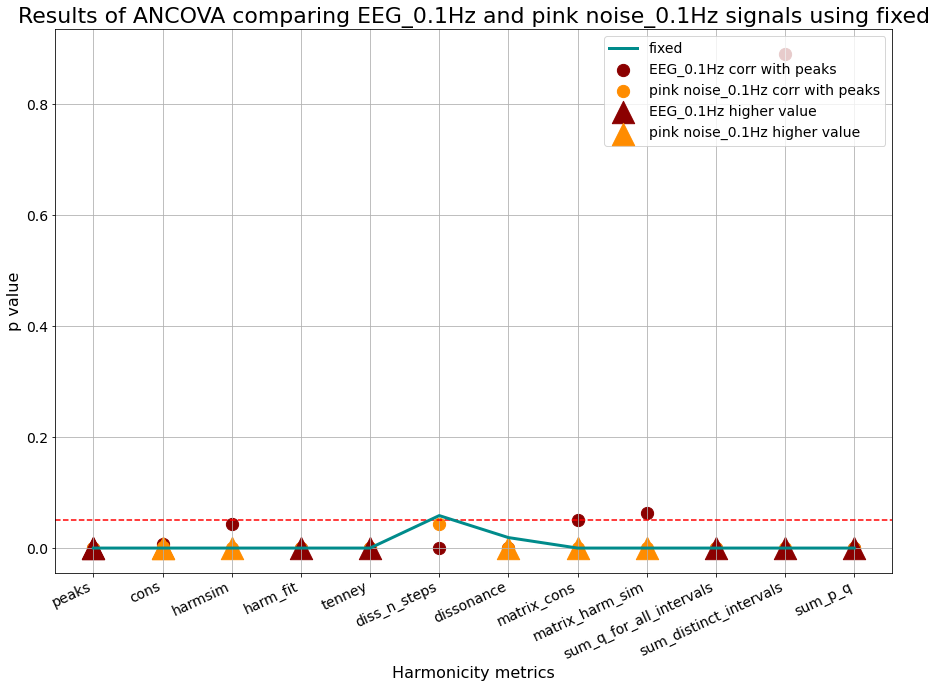

In [14]:
peaks_functions = ['fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'FOOOF', 'FOOOF_EEMD', 'HH1D_max', 'EMD', 'EEMD']
plt.rcParams['axes.facecolor'] = 'white'
ttest_all, tvals, avg_all = ttest_all_metrics_all_functions(EEG_metrics, pink_metrics, 
                                                            peaks_functions, data_types=['EEG', 'pink'])
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise', 'darkblue', 'orange']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all, function, labels = ['EEG_0.1Hz', 'pink noise_0.1Hz'], 
                           peaks_corr1=peaks_p_eeg, peaks_corr2=peaks_p_pink, color=color, save=True, avg_all=avg_all)

## Which harmonicity metrics best distinguish between EEG and surrogate data ?

In [24]:
phase_data = surrogate_signal_matrices(EEG_data[0:240, 2000:7000], surr_type = 'phase', low_cut = 0.5, high_cut = 150, sf = 1000)

In [28]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'HH1D_max', 'FOOOF', 'FOOOF_EEMD', 'EMD', 'EEMD']
peaks_corr_phase, peaks_p_phase, phase_metrics = compare_corr_metrics_peaks(phase_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          chords_metrics=False, save=True, fname='phase_metrics_0.5Hz')



fixed
adapt
cepstrum
harmonic_peaks
HH1D_max
FOOOF
FOOOF_EEMD
EMD
EEMD


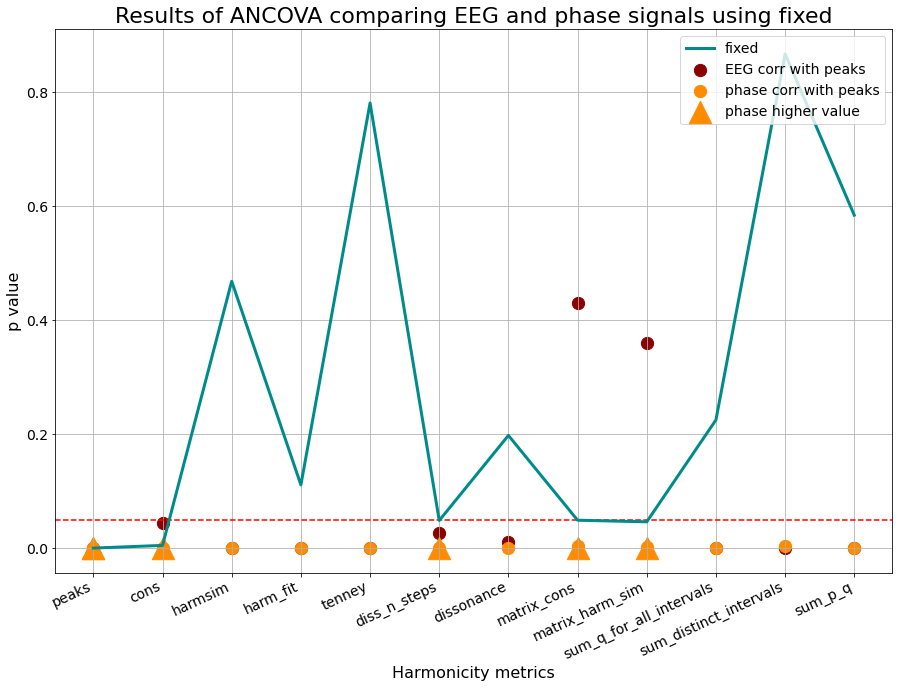

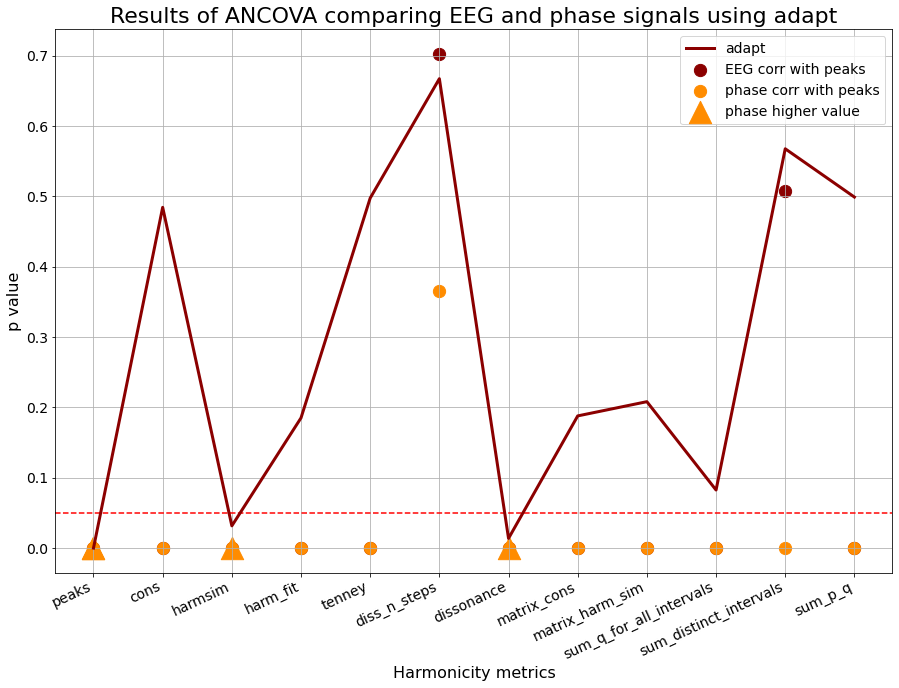

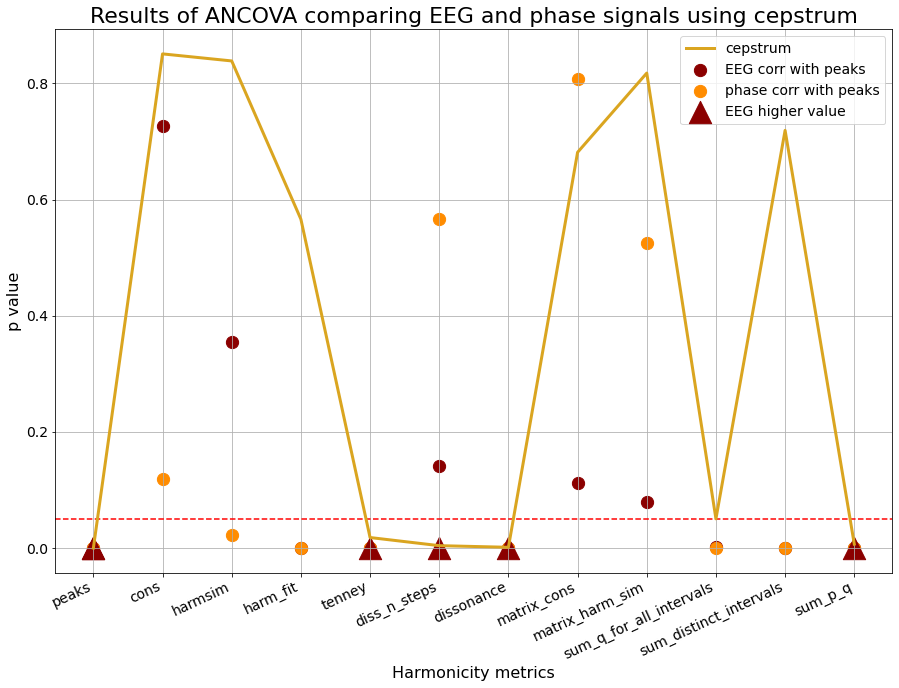

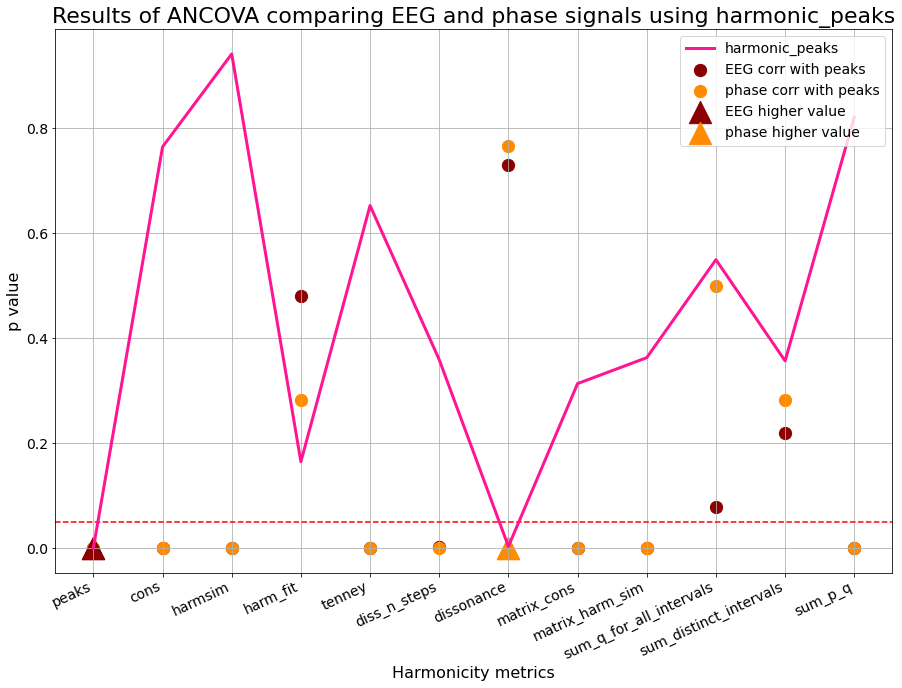

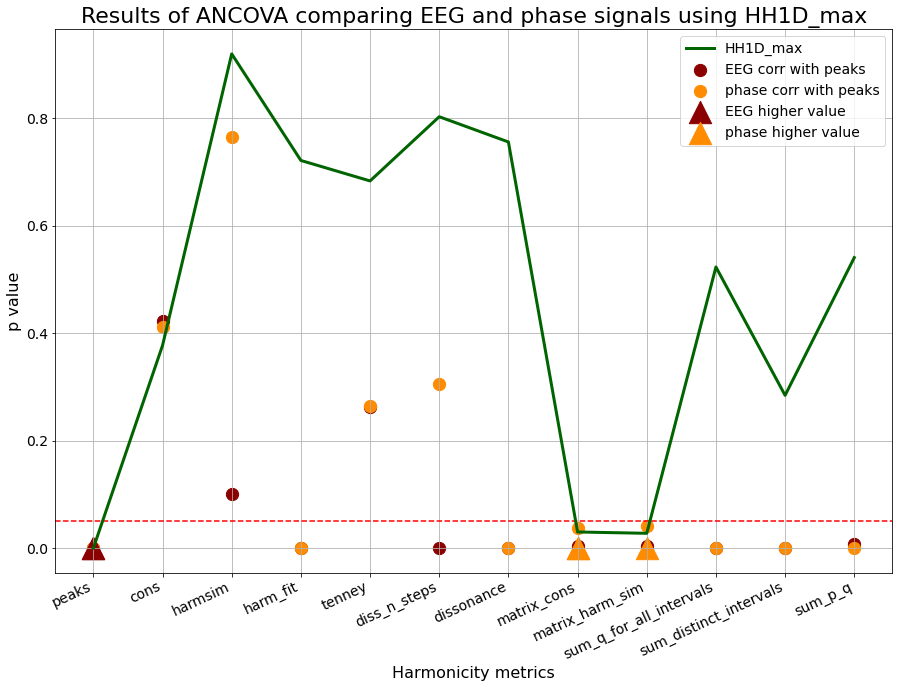

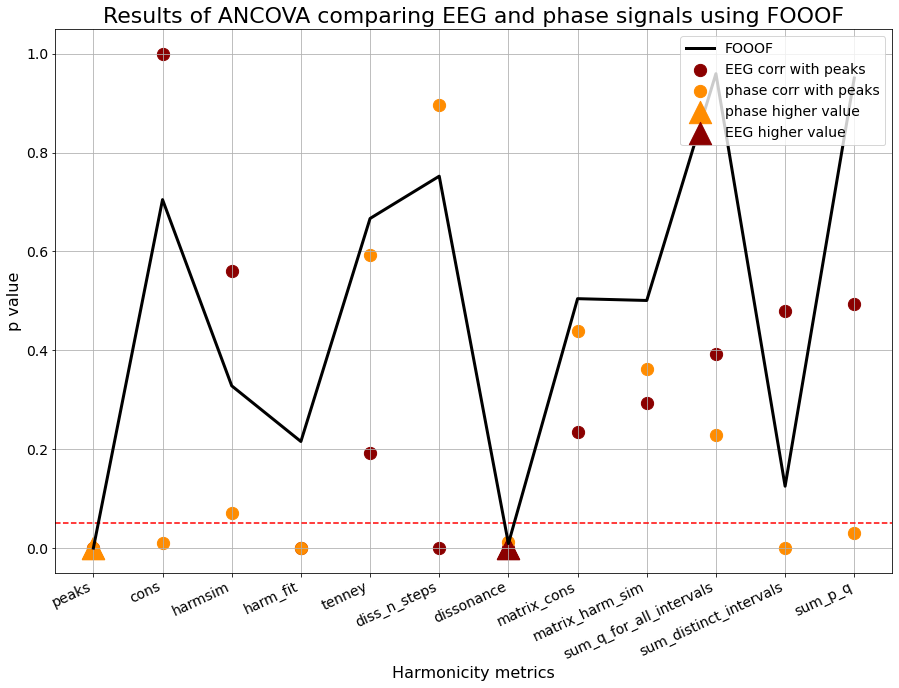

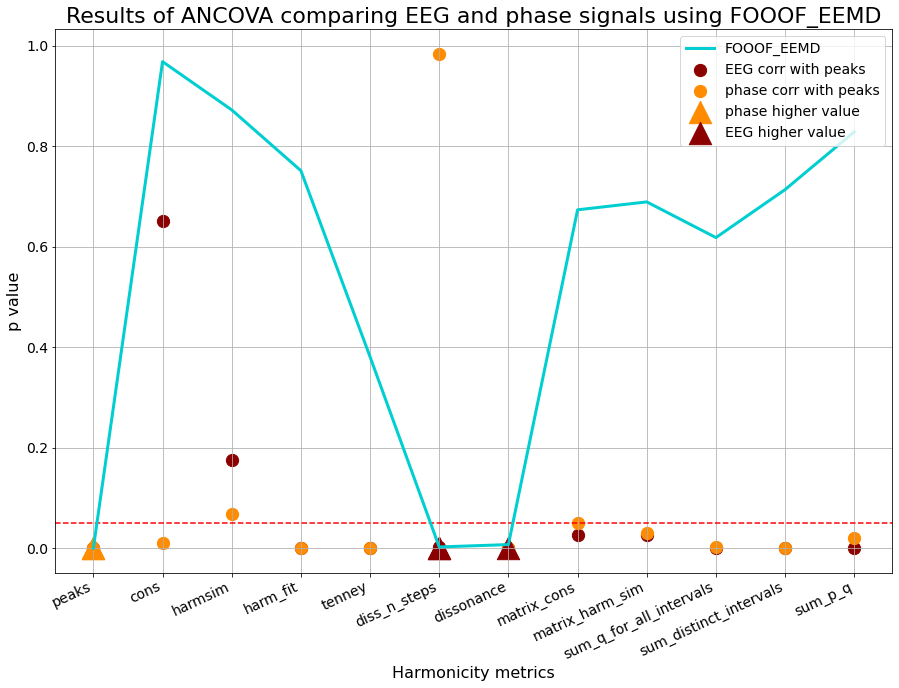

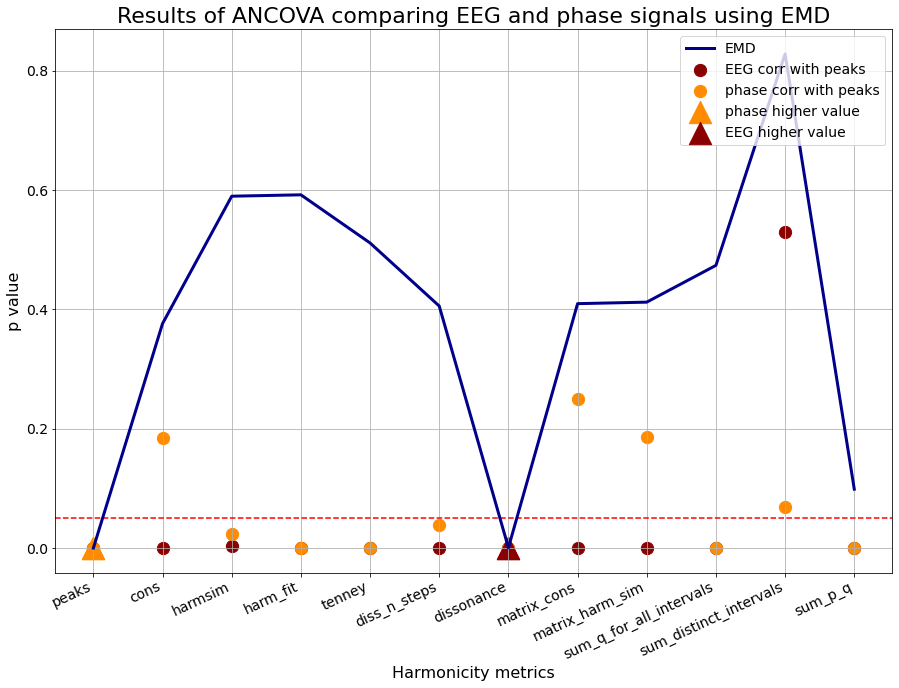

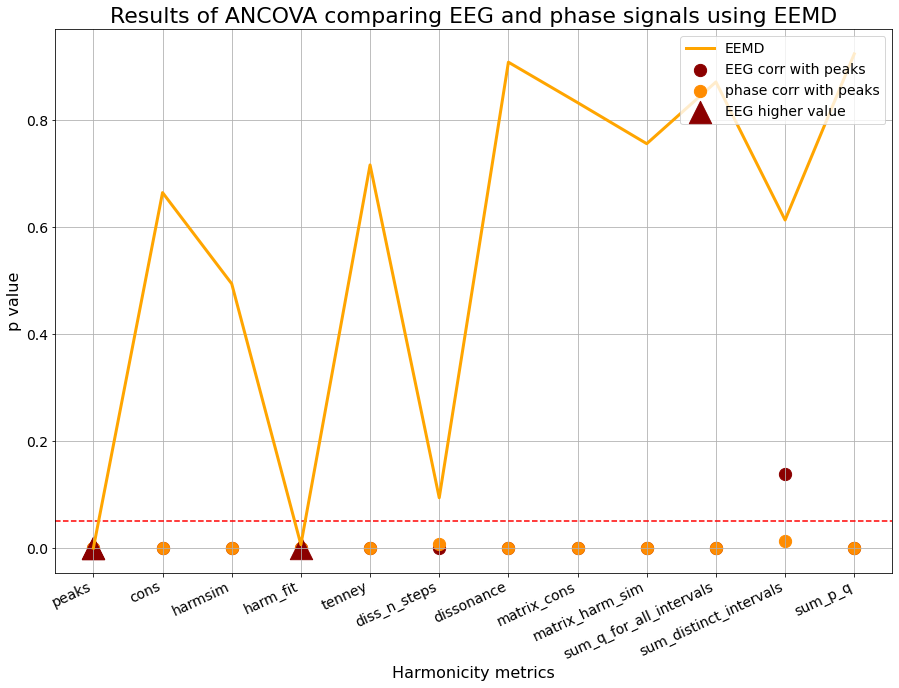

In [31]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all, tvals, avg_all = ttest_all_metrics_all_functions(EEG_metrics, phase_metrics, 
                                                            peaks_functions, data_types=['EEG', 'phase'])
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise', 'darkblue', 'orange']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all, function, labels = ['EEG', 'phase'], 
                           peaks_corr1=peaks_p_eeg, peaks_corr2=peaks_p_phase, color=color, save=True, avg_all=avg_all)

In [3]:
AAFT_data = surrogate_signal_matrices(EEG_data[0:240, 2000:7000], surr_type = 'AAFT', low_cut = 0.5, high_cut = 150, sf = 1000)

In [ ]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'HH1D_max', 'FOOOF', 'FOOOF_EEMD', 'EMD', 'EEMD']
peaks_corr_AAFT, peaks_p_AAFT, AAFT_metrics = compare_corr_metrics_peaks(AAFT_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.1, FREQ_BANDS = FREQ_BANDS,
                                                          chords_metrics=False, save=True, fname='AAFT_metrics_0.1Hz')



fixed
adapt
cepstrum
harmonic_peaks
HH1D_max


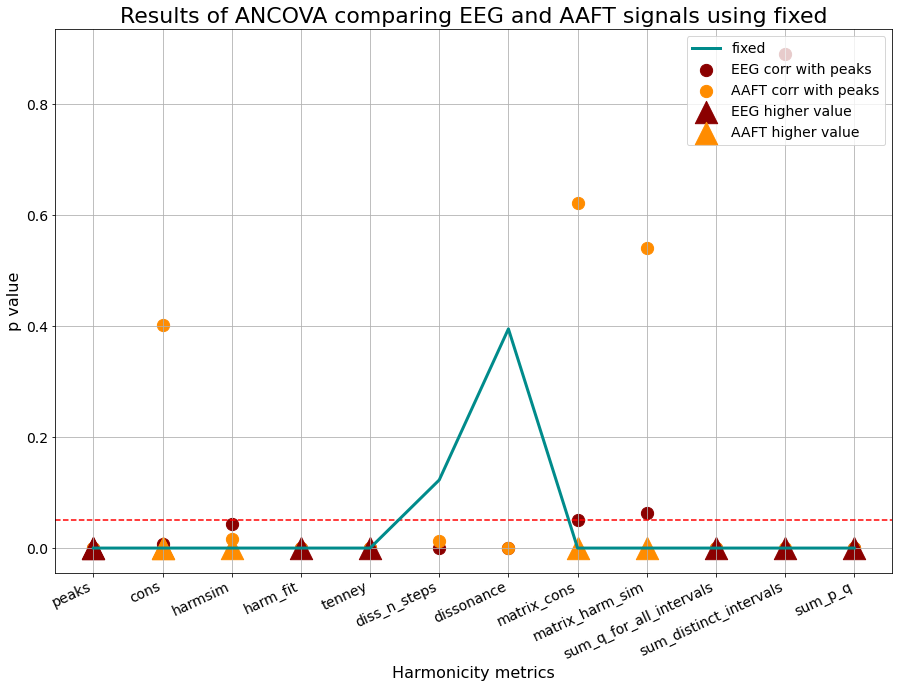

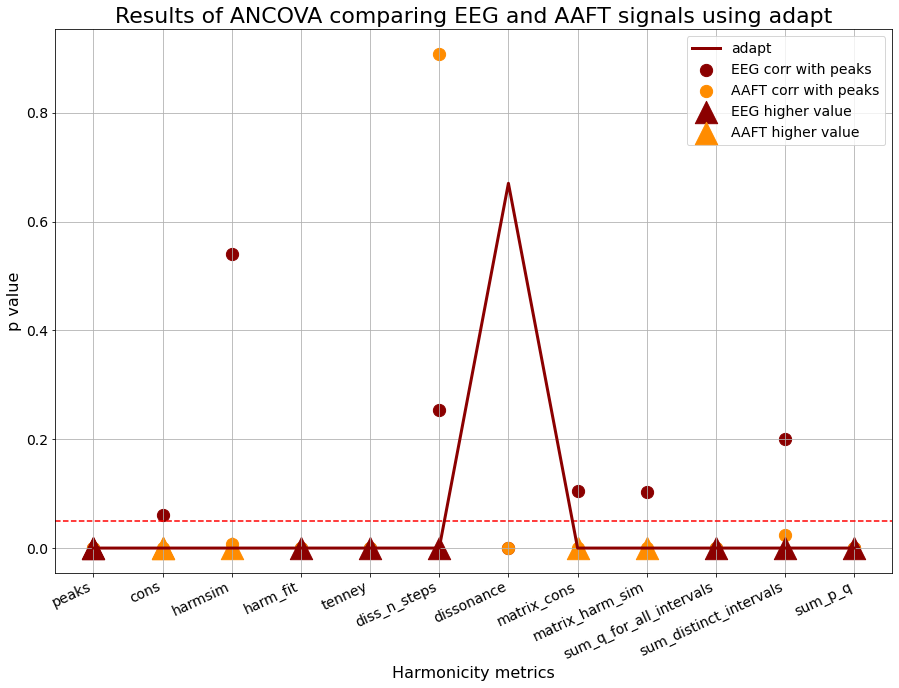

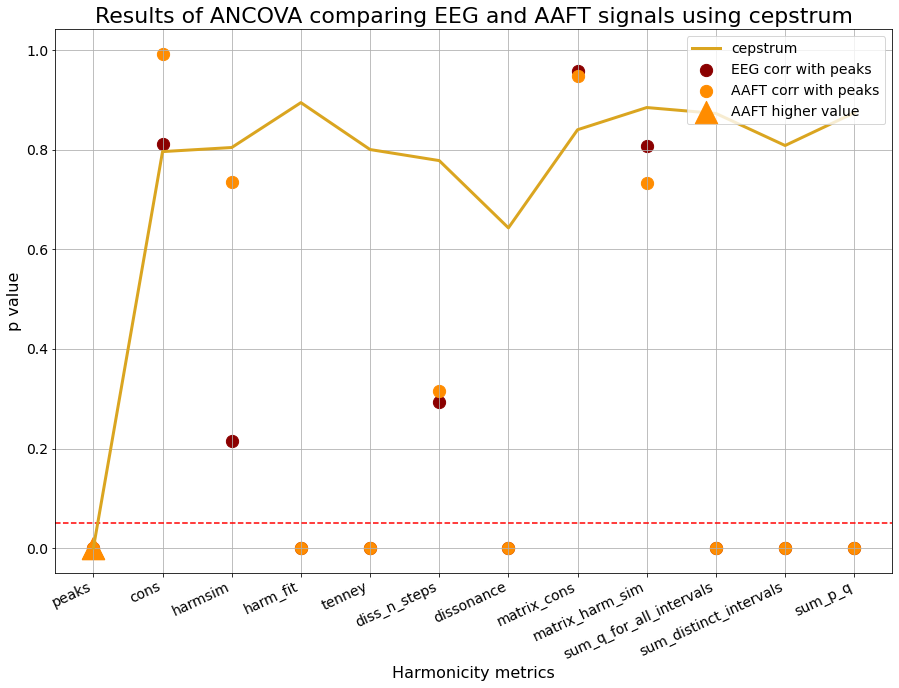

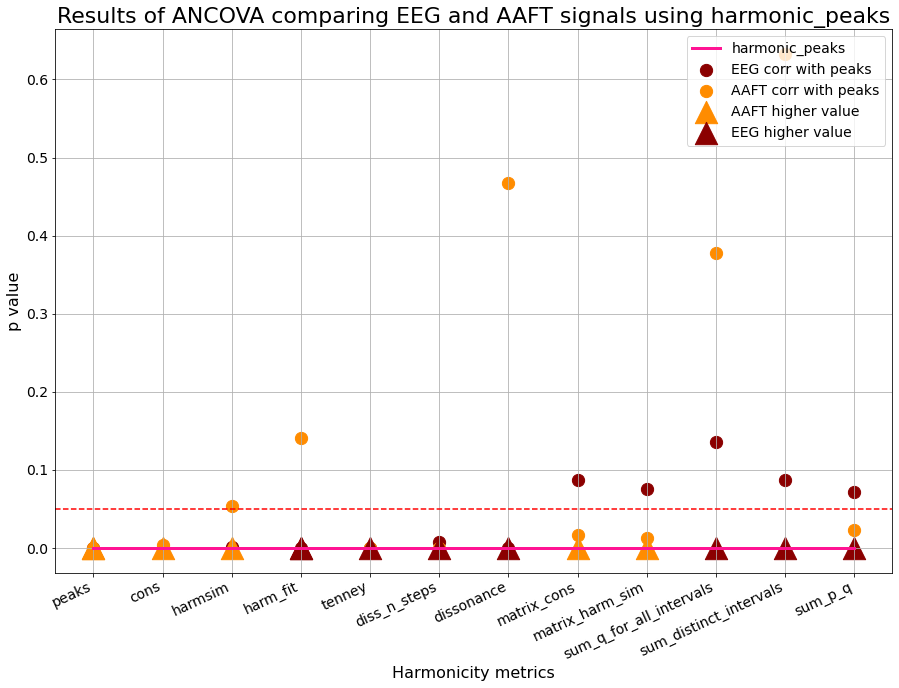

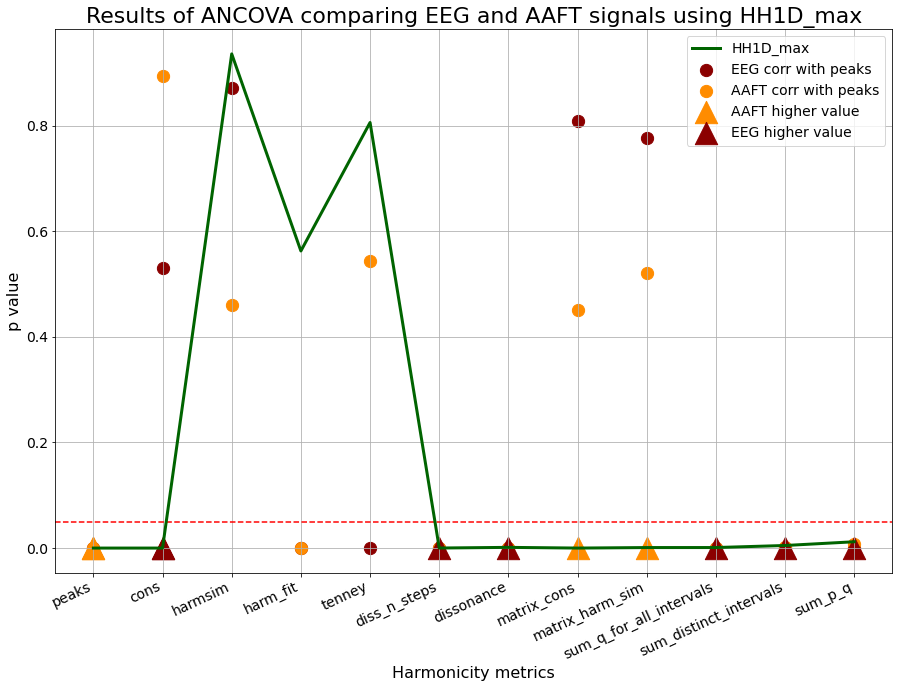

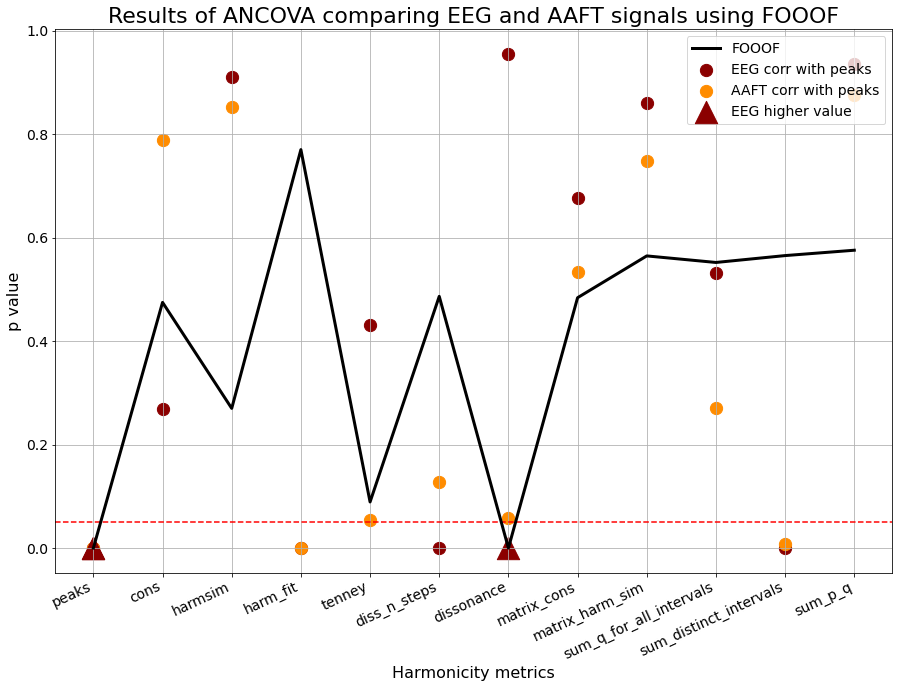

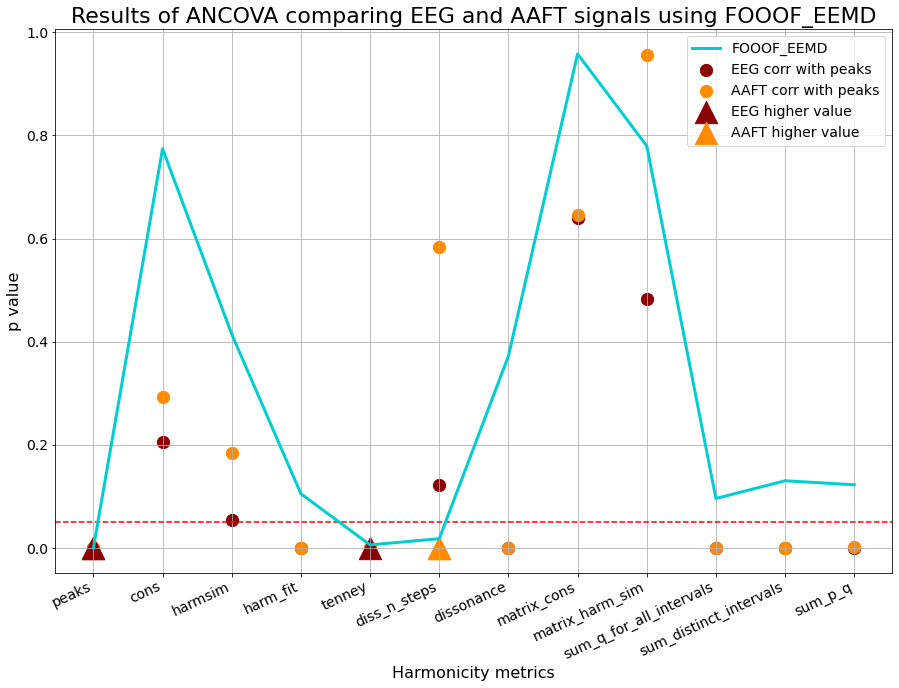

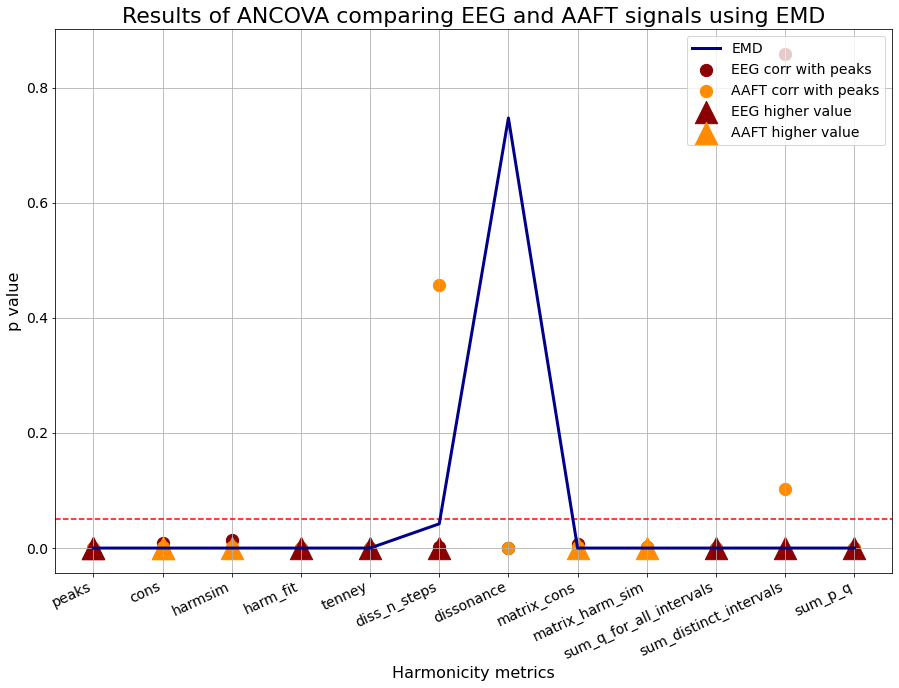

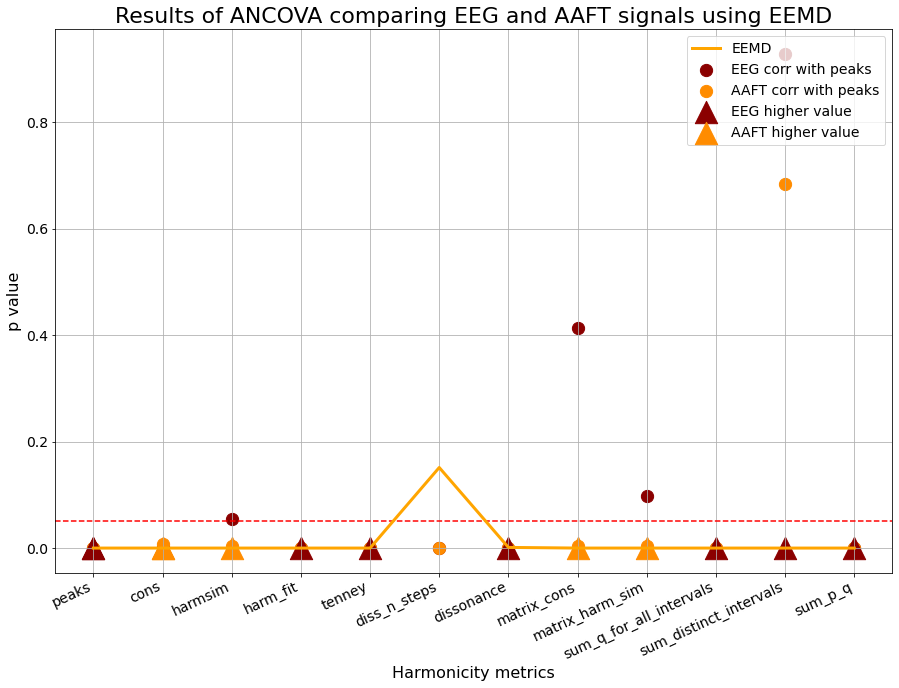

In [26]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all, tvals, avg_all = ttest_all_metrics_all_functions(EEG_metrics, AAFT_metrics, 
                                                            peaks_functions, data_types=['EEG', 'AAFT'])
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise', 'darkblue', 'orange']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all, function, labels = ['EEG', 'AAFT'], 
                           peaks_corr1=peaks_p_eeg, peaks_corr2=peaks_p_AAFT, color=color, save=True, avg_all=avg_all)

      Source            SS   DF           F         p-unc       np2
0  data_type  34403.375178    1  538.526648  2.692456e-80  0.530293
1      peaks   1024.884179    1   16.042828  7.181336e-05  0.032538
2   Residual  30472.790955  477         NaN           NaN       NaN


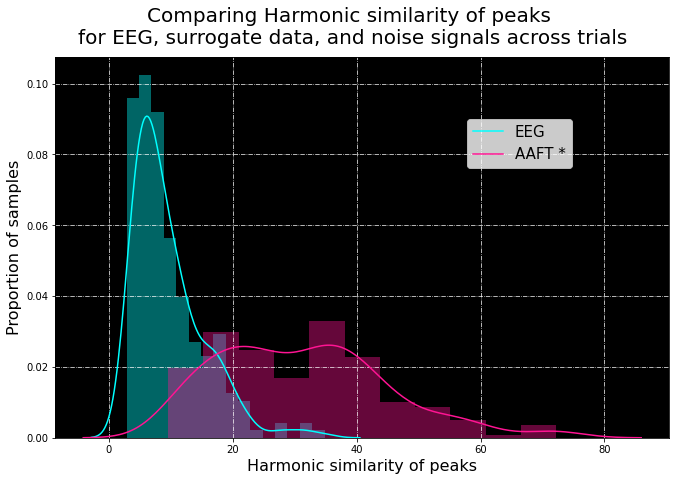

In [30]:
method ='EMD'
metric='harmsim'
data_types=['EEG', 'AAFT']
print(ancova_biotuner2d(EEG_metrics, AAFT_metrics, method, metric, data_types, plot=False))

test_graph = [EEG_metrics.loc[method][metric], pink_metrics.loc[method][metric]]
graph_dist(test_graph, metric = metric, ref = test_graph[0], dimensions = [0], labs = data_types, 
           savefolder = '\\', subject = '0', tag = '0', adapt = 'False', 
           peaks_function = method, colors = None, display = True, save = False, title=None)

## Comparing pareidolia vs non-pareidolia in the visual cortex

In [3]:
par_data = np.load('data_examples/EEG_pareidolia/parei_occi_L.npy')
nopar_data = np.load('data_examples/EEG_pareidolia/no_parei_occi_L.npy')

par_data, nopar_data = equate_dimensions(par_data, nopar_data)

par_data.shape, nopar_data.shape

((138, 5000), (138, 5000))

In [4]:
peaks_functions = ['fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'FOOOF', 'HH1D_max', 'EMD', 'EEMD']
peaks_corr_par, peaks_p_par, par_metrics = compare_corr_metrics_peaks(par_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = None,
                                                          chords_metrics=False, save=True,
                                                                     fname='par_0.5Hz_')
peaks_corr_nopar, peaks_p_nopar, nopar_metrics = compare_corr_metrics_peaks(nopar_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = None,
                                                          chords_metrics=False, save=True, 
                                                                            fname='nopar_0.5Hz_')


fixed
adapt
cepstrum
harmonic_peaks
FOOOF
HH1D_max
EMD
EEMD
fixed
adapt
cepstrum
harmonic_peaks
FOOOF
HH1D_max
EMD
EEMD


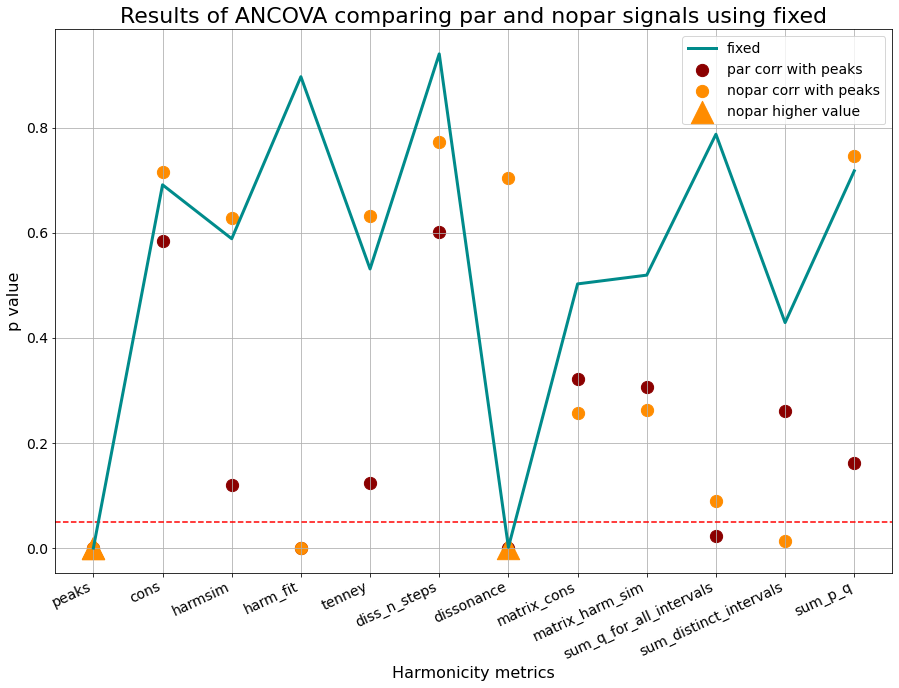

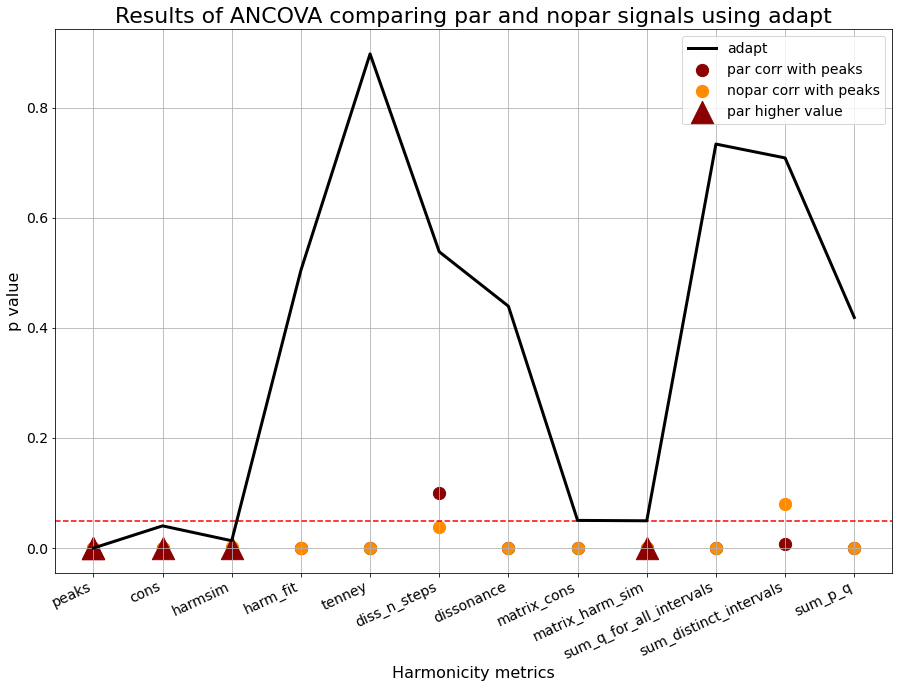

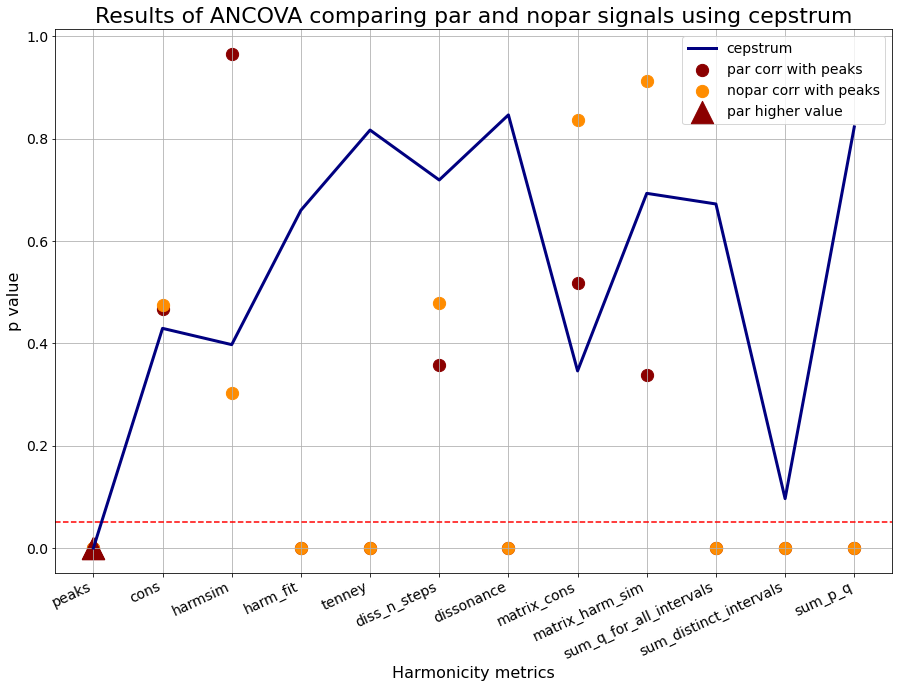

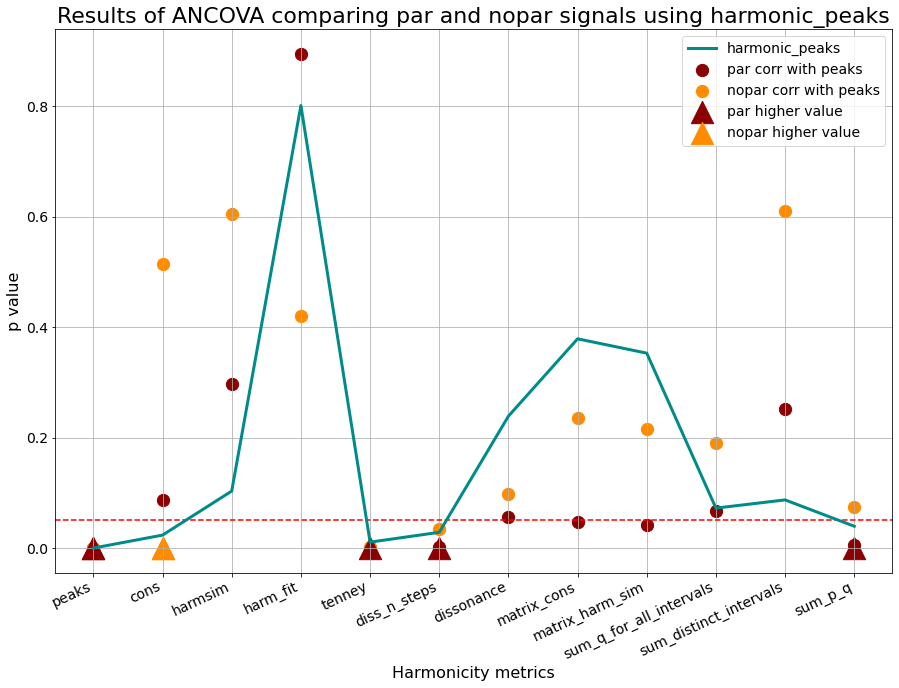

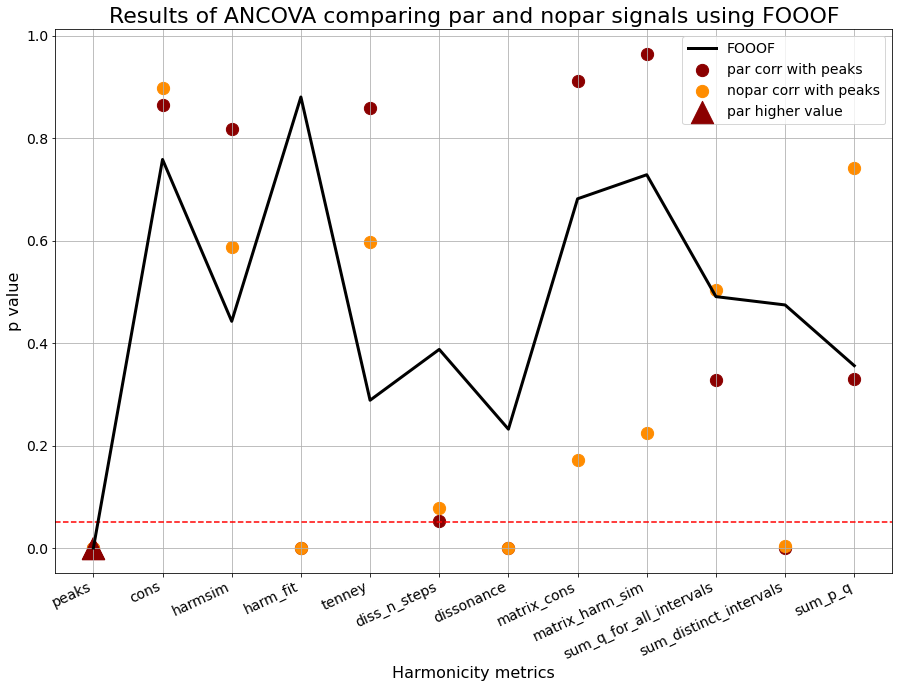

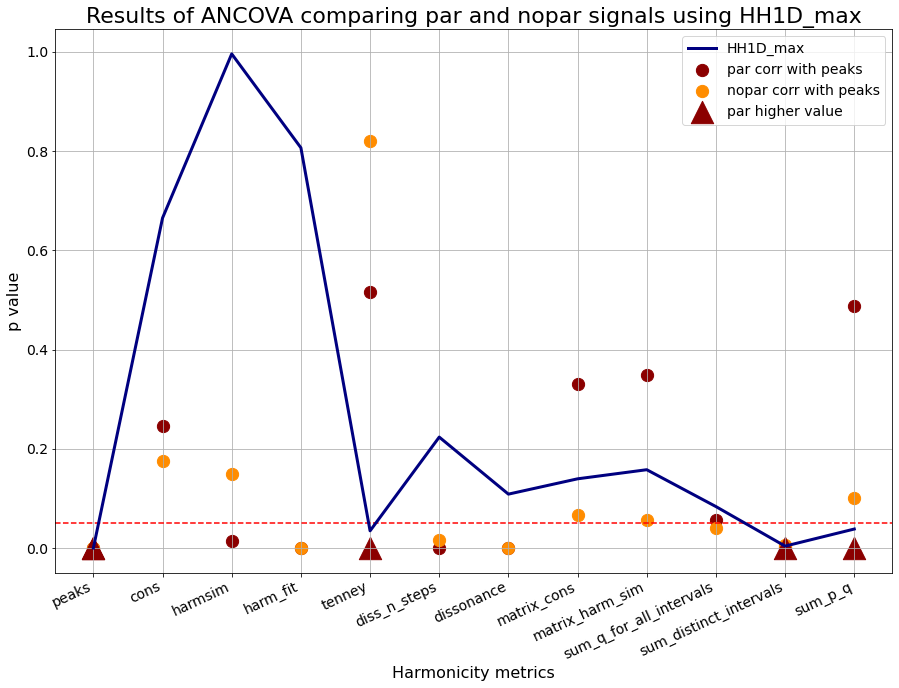

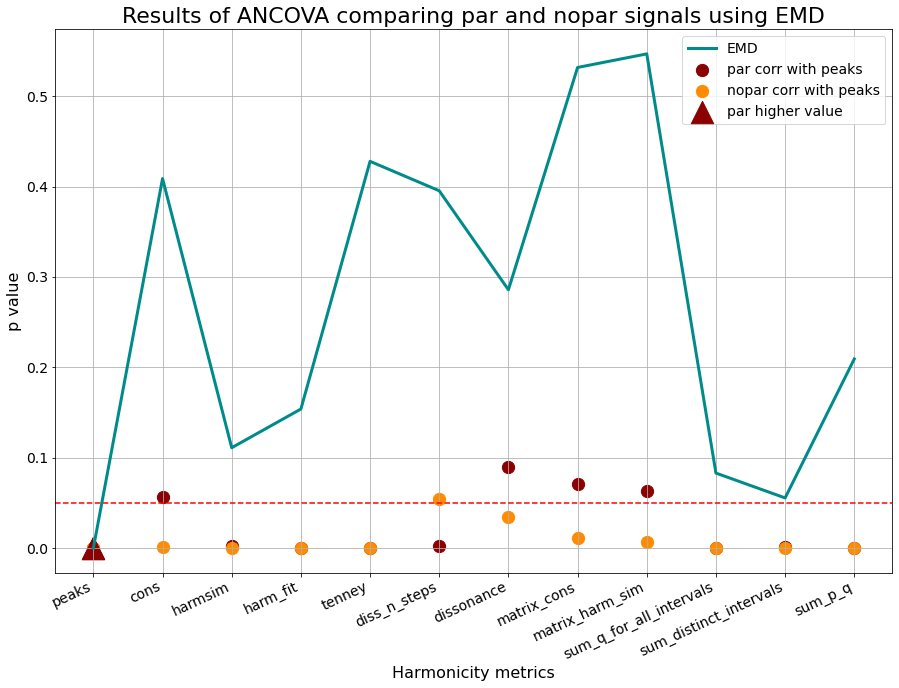

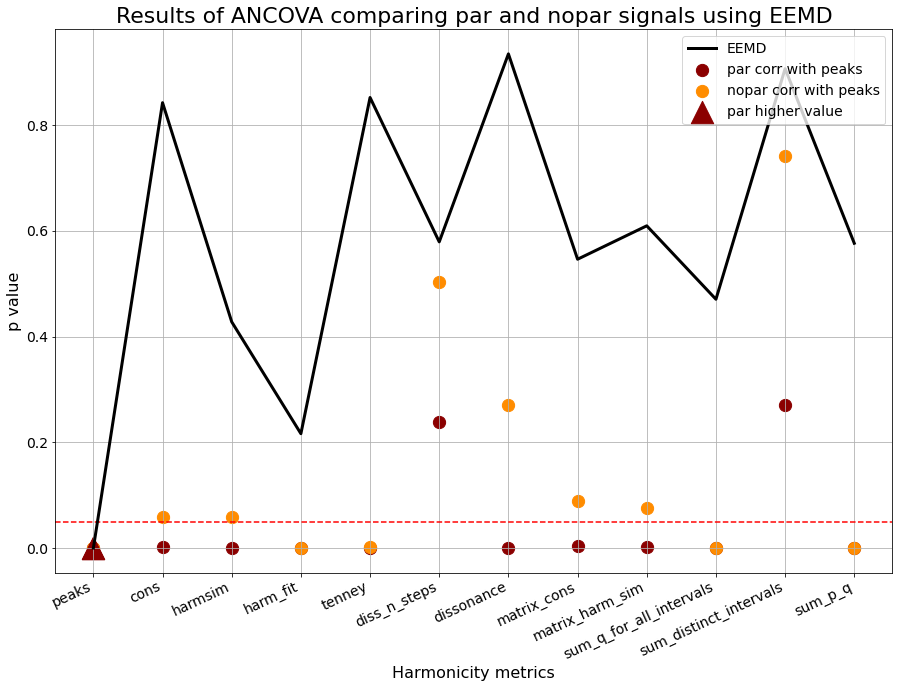

In [84]:
plt.rcParams['axes.facecolor'] = 'white'
ANCOVA_parNOpar, F_parNOpar, avg_all = ttest_all_metrics_all_functions(par_metrics, nopar_metrics, peaks_functions, data_types=['par', 'nopar'])
colors = ['darkcyan', 'black', 'navy','darkcyan', 'black', 'navy', 'darkcyan', 'black', 'navy']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ANCOVA_parNOpar, function, labels = ['par', 'nopar'], 
                           peaks_corr1=peaks_p_par, peaks_corr2=peaks_p_nopar, color=color, save=True, avg_all=avg_all)

In [159]:
par = par_metrics.reset_index(level=1, drop=True)
nopar = nopar_metrics.reset_index(level=1, drop=True)

nan 1.8231202421486221


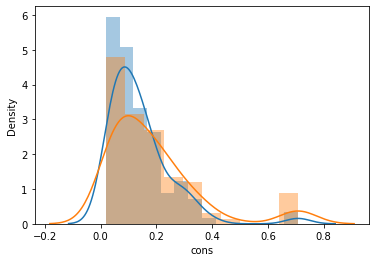

In [160]:
sbn.distplot(par.loc['harmonic_peaks', 'cons'])
sbn.distplot(nopar.loc['harmonic_peaks', 'cons'])

x = skew(list(par.loc['harmonic_peaks', 'cons']))
y = skew(list(nopar.loc['harmonic_peaks', 'cons']))
print(x, y)
#par.loc['EEMD', 'harmsim']

In [25]:
def normalize_metrics_df(df_):
    df = df_.copy()
    df = df.replace(0, 0.1)
    methods = df.index.unique().tolist()
    #print(methods)
    metrics = list(df)
    #print(metrics)
    for method in methods:
        for metric in metrics:
            x = skew(list(df.loc[method, metric]))
            if x > 0.3 and x <= 2:  
                lmbda = 0
            if x > 2: 
                lmbda = -1
            if x < -0.3 and x >= -2:  
                lmbda = 2.5
            #if x < -2:  
            #    lmbda = 3.5
            if x > 0.3 or x < -0.3:
                df.loc[method,metric] = boxcox(df.loc[method][metric], lmbda)
            a = df.loc[method,metric]    
            df.loc[method,metric] = np.interp(a, (a.min(), a.max()), (0, 1))
    return df

In [155]:
from scipy.stats import boxcox
from scipy.stats import skew
par = normalize_metrics_df(par)
nopar = normalize_metrics_df(nopar)

['fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'FOOOF', 'HH1D_max', 'EMD', 'EEMD']
['peaks', 'cons', 'harmsim', 'harm_fit', 'tenney', 'diss_n_steps', 'dissonance', 'matrix_cons', 'matrix_harm_sim', 'sum_q_for_all_intervals', 'sum_distinct_intervals', 'sum_p_q']
['fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'FOOOF', 'HH1D_max', 'EMD', 'EEMD']
['peaks', 'cons', 'harmsim', 'harm_fit', 'tenney', 'diss_n_steps', 'dissonance', 'matrix_cons', 'matrix_harm_sim', 'sum_q_for_all_intervals', 'sum_distinct_intervals', 'sum_p_q']


6.210142221934365

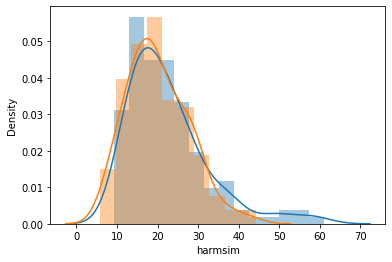

In [167]:
a = ancova_biotuner2d(par, nopar, 'adapt', 'harmsim', ['par', 'nopar'], plot=True)
a['p-unc'][0]
a['F'][0]

cons    harmsim  harm_fit    tenney  diss_n_steps  dissonance  \
fixed  0.350338  30.598291        10  5.024310             3    0.479362   
fixed  0.206640  19.668752         9  6.355748             6    0.749360   
fixed  0.118691  12.611325         8  7.431586             3    0.563505   
fixed  0.099255  10.985790        11  8.075755             4    0.621793   
fixed  0.073598  19.847746        10  8.033006             5    0.662122   
...         ...        ...       ...       ...           ...         ...   
EEMD   0.239106  21.608504        10  7.128207             4    1.335172   
EEMD   0.189290  18.670935         8  7.120532             4    0.434388   
EEMD   0.223365  22.352919        12  6.184369             5    0.764221   
EEMD   0.204351  20.933081        10  5.620448             4    0.609229   
EEMD   0.260863  38.380952        15  4.964162             3    0.920876   

       matrix_cons  matrix_harm_sim  sum_q_for_all_intervals  \
fixed     0.249902        22.451282                    383.0   
fixed     0.124732        11.565218                   2445.0   
fixed     0.070885         6.769024                  10633.0   
fixed     0.054874         5.241923                  15445.0   
fixed     0.047070         4.571097                  10446.0   
...            ...              ...                      ...   
EEMD      0.121890        11.117453                   5381.0   
EEMD      0.132652        11.545186                  20083.0   
EEMD      0.155519        14.032155                   8581.0   
EEMD      0.168113        15.166051                   6107.0   
EEMD      0.163617        15.379705                    697.0   

       sum_distinct_intervals  sum_p_q  
fixed                    22.0    128.0  
fixed                    26.0    354.0  
fixed                    58.0    427.0  
fixed                    68.0    477.0  
fixed                    30.0    475.0  
...                       ...      ...  
EEMD                     66.0    299.0  
EEMD                     66.0    622.0  
EEMD                     70.0    348.0  
EEMD                     68.0    390.0  
EEMD                     12.0     97.0  

[1083 rows x 11 columns]

In [215]:
df_total = pd.concat([EEG_metrics.loc['EEMD'], ECG_metrics.loc['EEMD']],keys=['EEG', 'ECG']).reset_index()
df_total.rename(columns={'level_0': 'data_type'}, inplace=True)


ancova(data=df_total, dv='matrix_cons', covar='peaks', between='data_type')

Source          SS   DF          F         p-unc       np2
0  data_type    6.927048    1  27.260455  2.661800e-07  0.054168
1      peaks   18.964928    1  74.633892  8.636413e-17  0.135542
2   Residual  120.954508  476        NaN           NaN       NaN

In [213]:
from scipy.stats import boxcox
EEG_metrics.loc['EEMD','matrix_cons'] = boxcox(EEG_metrics.loc['EEMD']['matrix_cons'], 0)
ECG_metrics.loc['EEMD','matrix_cons'] = boxcox(ECG_metrics.loc['EEMD']['matrix_cons'], 0)
#sbn.displot(data)
#sbn.displot(ECG_metrics.loc['fixed']['harmsim'])

<AxesSubplot:xlabel='matrix_cons', ylabel='Density'>

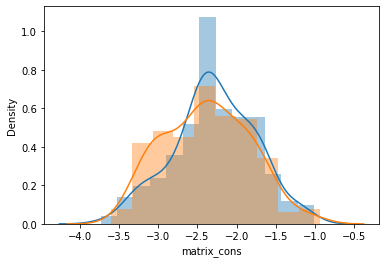

In [214]:
sbn.distplot(EEG_metrics.loc['EEMD','matrix_cons'])
sbn.distplot(ECG_metrics.loc['EEMD','matrix_cons'])

In [187]:
from scipy.stats import kstest
from scipy import stats
k2, p = stats.normaltest(EEG_metrics.loc['EEMD']['harmsim'])
p

0.29396237952077237

In [206]:
EEG_metrics = pd.read_csv('EEG_metrics_0.5Hz.csv', index_col='method')
ECG_metrics = pd.read_csv('ECG_metrics_0.5Hz.csv', index_col='method')